In [1]:
### Import libraries

import math
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import learning_curve
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import mean_squared_error
#import keras
#import tensorflow as tf
import xgboost as xgb
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer

/opt/homebrew/Caskroom/miniforge/base/envs/pytorch_env/lib/python3.9/site-packages/xgboost/compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index


In [2]:
## Read data and rename columns ###
orig_data = pd.read_excel("OppScrData.xlsx")
for col in orig_data.columns:
    new_col = '_'.join(col.split())
    orig_data.rename(columns={col:new_col}, inplace=True)

In [3]:
## remove 'Unknown' column headers
orig_data.columns[:55]

Index(['Record_ID', 'Visit_ID', 'PT_ID', 'Clinical_F/U_interval_[d_from_CT]',
       'BMI', 'BMI_>30', 'Sex', 'Age_at_CT', 'Tobacco', 'Alcohol_abuse',
       'FRS_10-year_risk_(%)', 'FRAX_10y_Fx_Prob_(Orange-w/_DXA)',
       'FRAX_10y_Hip_Fx_Prob_(Orange-w/_DXA)', 'Met_Sx', 'CLINICAL_OUTCOMES',
       'DEATH_[d_from_CT]', 'CVD_DX', 'CVD_DX_Date_[d_from_CT]',
       'Heart_failure_DX', 'Heart_failure_DX_Date_[d_from_CT]', 'MI_DX',
       'MI_DX_Date_[d_from_CT]', 'Type_2_Diabetes_DX',
       'Type_2_Diabetes_DX_Date_[d_from_CT]', 'Femoral_neck_fracture_DX',
       'Femoral_neck_fracture_DX_Date_[d_from_CT]',
       'Unspec_femoral_fracture_DX',
       'Unspec_femoral_fracture_DX_Date_[d_from_CT]', 'Forearm_fracture_DX',
       'Forearm_fracture_DX_Date_[d_from_CT]', 'Humerus_fracture_DX',
       'Humerus_fracture_DX_Date_[d_from_CT]', 'Pathologic_fracture_DX',
       'Pathologic_fracture_DX_Date_[d_from_CT]', 'Alzheimers_DX',
       'Alzheimers_DX_Date_[d_from_CT]', 'Primary_Cancer_Site

# Death

In [4]:
## Data setup for predicting 'DEATH_[d_from_CT]'

data = orig_data.copy()

data['BMI_>30'] = np.where(data['BMI_>30']=='Y', 1, 0)
data.rename(columns={'BMI_>30':'BMI_more_than_30'}, inplace=True)
data['Sex'] = np.where(data['Sex']=='Male', 1, 0)
data['Tobacco'] = np.where(data['Tobacco']=='Yes', 1, 0)

## Zero the NULL values
data['Alcohol_abuse'] = np.where(data['Alcohol_abuse'].isna(),0,1)


### Convert percentage values into uniform numeric values
col = 'FRS_10-year_risk_(%)'
data[col] = data[col].astype(str)
data[col] = data[col].str.replace('X','')
data[col] = data[col].str.replace('<1%',str(np.random.uniform(0, 0.01)))
data[col] = data[col].str.replace('>30%',str(np.random.uniform(0.3, 0.99)))
data[col] = pd.to_numeric(data[col], errors='coerce')
data[col] = data[col].astype(float)
med = data[col].median()
data[col] = data[col].fillna(med)
upper_limit = data[col].quantile(0.99)
data[col] = data[col].clip(upper_limit)


## clip outliers to 95th percentile
for col in ['FRAX_10y_Fx_Prob_(Orange-w/_DXA)','FRAX_10y_Hip_Fx_Prob_(Orange-w/_DXA)']:
    data[col] = data[col].astype(str)
    data[col] = data[col].str.replace('_','')
    data[col] = pd.to_numeric(data[col], errors='coerce')
    data[col] = data[col].astype(float)
    med = data[col].median()
    data[col] = data[col].fillna(med)
    upper_limit = data[col].quantile(0.95)
    data[col] = data[col].clip(upper_limit)

    
data['Met_Sx'] = np.where(data['Met_Sx']=='Y', 1, np.where(data['Met_Sx']=='N', 0, -1))


data['CVD'] = np.where(data['CVD_DX'].isna(),0,1)
data['MI'] = np.where(data['MI_DX'].isna(),0,1)
data['Heart_failure'] = np.where(data['Heart_failure_DX'].isna(),0,1)


## The main column we are predicting is stored in 'days'
data['days'] = data['DEATH_[d_from_CT]']

data['diabetes'] = np.where(data['Type_2_Diabetes_DX'].isna(), 0, 1)


data['L1_HU_BMD'] = data['L1_HU_BMD'].clip(lower=0)

## Created a new column of Fat are/ Total body area
data['TAT/Body_Area'] = data['TAT_Area_(cm2)']/data['Total_Body_Area_EA_(cm2)']
col = 'VAT_Area_(cm2)'
upper_limit = data[col].quantile(0.99)
data[col] = data[col].clip(upper_limit)
col = 'SAT_Area_(cm2)'
upper_limit = data[col].quantile(0.99)
data[col] = data[col].clip(upper_limit)
col = 'VAT/SAT_Ratio'
upper_limit = data[col].quantile(0.95)
data[col] = data[col].clip(upper_limit)

data['AoCa_Agatston'] = data['AoCa_Agatston'].clip(upper=data['AoCa_Agatston'].quantile(0.99))
data['AoCa_Agatston'] = data['AoCa_Agatston'].fillna(data['AoCa_Agatston'].median())
data['AoCa_Agatston'] = np.log(data['AoCa_Agatston']+1)

data['Liver_HU_(Median)'] = pd.to_numeric(data['Liver_HU_(Median)'], errors='coerce')
data['Liver_HU_(Median)'] = data['Liver_HU_(Median)'].astype(float)
#data['Liver_HU_(Median)'] = data['Liver_HU_(Median)'].fillna(data['Liver_HU_(Median)'].median())
                          
for col in ['BMI','TAT_Area_(cm2)', 'Total_Body_Area_EA_(cm2)', 'VAT_Area_(cm2)','SAT_Area_(cm2)',
            'Muscle_Area_(cm2)','TAT/Body_Area']:
    data[col] = data[col].fillna(data[col].median())


### Below features filled by iterative imputing
# 'L1_HU_BMD'
# 'VAT/SAT_Ratio'
# 'Muscle_HU'
# L3_SMI_(cm2/m2)
# Liver_HU_(Median)

impute_it = IterativeImputer()

col = 'L1_HU_BMD'
# ind = data.index[data[col].isna()].tolist()
#print(len(data.loc[data[col] < 100, col]))
#print(data.loc[data[col].isna(), 'L1_HU_BMD'])
rel_cols = ['Age_at_CT', 'Muscle_HU', 'L1_HU_BMD']
X = data[rel_cols]
X = impute_it.fit_transform(X)
# print(X[:, 2])
data[col] = X[:, 2]
# print(col, data[col].isna().sum())

### VAT/SAT ratio -- Muscle area, Sex

col = 'VAT/SAT_Ratio'
rel_cols = ['Muscle_Area_(cm2)', 'Sex', col]
X = data[rel_cols]
X = impute_it.fit_transform(X)
data[col] = X[:,2]


col = 'Muscle_HU'
rel_cols = ['Age_at_CT', 'TAT/Body_Area', col]
X = data[rel_cols]
X = impute_it.fit_transform(X)
data[col] = X[:,2]

col = 'L3_SMI_(cm2/m2)'
rel_cols = ['BMI_more_than_30', 'Sex', col]
X = data[rel_cols]
X = impute_it.fit_transform(X)
data[col] = X[:,2]
                       

col = 'Liver_HU_(Median)'                                     
rel_cols = ['BMI_more_than_30', 'TAT/Body_Area', col]
X = data[rel_cols]
X = impute_it.fit_transform(X)
data[col] = X[:,2]


In [5]:
# cols = ['Record_ID', 'Clinical_F/U_interval_[d_from_CT]', 'BMI', 'BMI_>30', 'Sex', 'Age_at_CT', 'Tobacco', 'Alcohol_abuse',
#        'FRS_10-year_risk_(%)', 'FRAX_10y_Fx_Prob_(Orange-w/_DXA)',
#        'FRAX_10y_Hip_Fx_Prob_(Orange-w/_DXA)', 'Met_Sx',
#        'days', 'CVD', 'CVD_DX_Date_[d_from_CT]',
#        'Heart_failure', 'Heart_failure_DX_Date_[d_from_CT]', 'MI',
#        'MI_DX_Date_[d_from_CT]', 'diabetes',
#        'Type_2_Diabetes_DX_Date_[d_from_CT]', 'Femoral_neck_fracture_DX',
#        'Femoral_neck_fracture_DX_Date_[d_from_CT]',
#        'Unspec_femoral_fracture_DX',
#        'Unspec_femoral_fracture_DX_Date_[d_from_CT]', 'Forearm_fracture_DX',
#        'Forearm_fracture_DX_Date_[d_from_CT]', 'Humerus_fracture_DX',
#        'Humerus_fracture_DX_Date_[d_from_CT]', 'Pathologic_fracture_DX',
#        'Pathologic_fracture_DX_Date_[d_from_CT]', 'Alzheimers_DX',
#        'Alzheimers_DX_Date_[d_from_CT]', 'Primary_Cancer_Site',
#        'Primary_Cancer_Dx_[d_from_CT]', 'Primary_Cancer_Site_2',
#        'Primary_Cancer_Site_2_Dx_[d_from_CT]', 'L1_HU_BMD',
#        'TAT_Area_(cm2)', 'Total_Body_Area_EA_(cm2)', 'TAT/Body_Area', 'VAT_Area_(cm2)',
#        'SAT_Area_(cm2)', 'VAT/SAT_Ratio', 'Muscle_HU', 'Muscle_Area_(cm2)',
#        'L3_SMI_(cm2/m2)', 'AoCa_Agatston', 'Liver_HU_(Median)']

cols = ['Record_ID', 'Clinical_F/U_interval_[d_from_CT]', 'BMI', 'BMI_more_than_30', 'Sex', 'Age_at_CT', 'Tobacco', 'Alcohol_abuse',
       'FRS_10-year_risk_(%)', 'FRAX_10y_Fx_Prob_(Orange-w/_DXA)',
       'FRAX_10y_Hip_Fx_Prob_(Orange-w/_DXA)', 'Met_Sx',
       'days', 'CVD', 'Heart_failure', 'MI', 'diabetes', 'L1_HU_BMD',
       'TAT_Area_(cm2)', 'Total_Body_Area_EA_(cm2)', 'TAT/Body_Area', 'VAT_Area_(cm2)',
       'SAT_Area_(cm2)', 'VAT/SAT_Ratio', 'Muscle_HU', 'Muscle_Area_(cm2)',
       'L3_SMI_(cm2/m2)', 'AoCa_Agatston', 'Liver_HU_(Median)']

#print(data['BMI_>30'])
data = data[cols].copy()
data['death_binary'] = np.where(data['days'].isna(),0,1)
print(data.isna().sum())

Record_ID                                  0
Clinical_F/U_interval_[d_from_CT]          0
BMI                                        0
BMI_more_than_30                           0
Sex                                        0
Age_at_CT                                  0
Tobacco                                    0
Alcohol_abuse                              0
FRS_10-year_risk_(%)                       0
FRAX_10y_Fx_Prob_(Orange-w/_DXA)           0
FRAX_10y_Hip_Fx_Prob_(Orange-w/_DXA)       0
Met_Sx                                     0
days                                    8674
CVD                                        0
Heart_failure                              0
MI                                         0
diabetes                                   0
L1_HU_BMD                                  0
TAT_Area_(cm2)                             0
Total_Body_Area_EA_(cm2)                   0
TAT/Body_Area                              0
VAT_Area_(cm2)                             0
SAT_Area_(

Record_ID


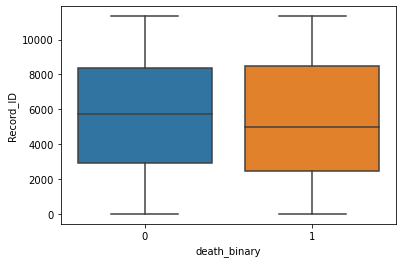

Clinical_F/U_interval_[d_from_CT]


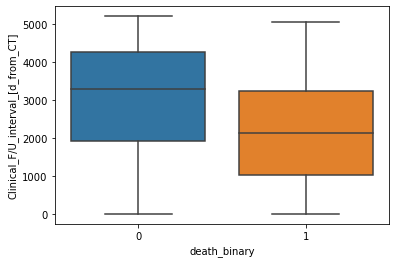

BMI


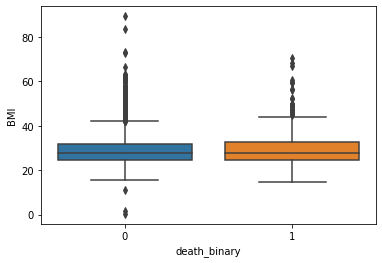

BMI_more_than_30


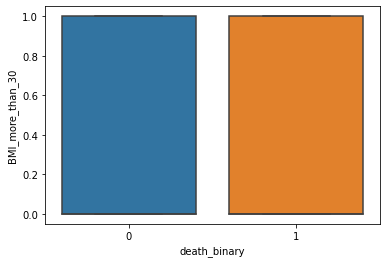

Sex


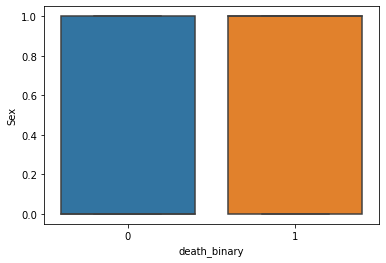

Age_at_CT


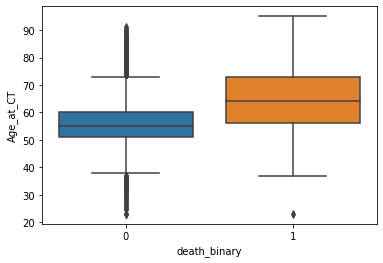

Tobacco


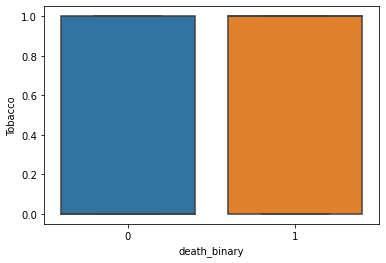

Alcohol_abuse


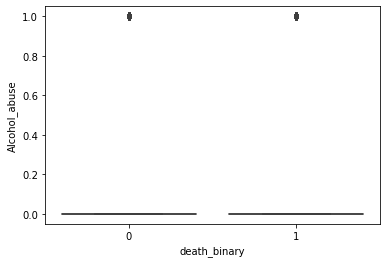

FRS_10-year_risk_(%)


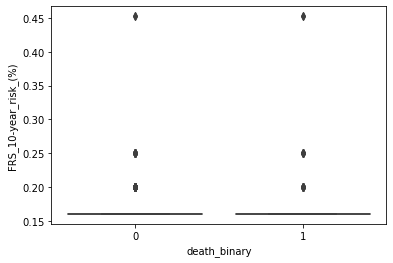

FRAX_10y_Fx_Prob_(Orange-w/_DXA)


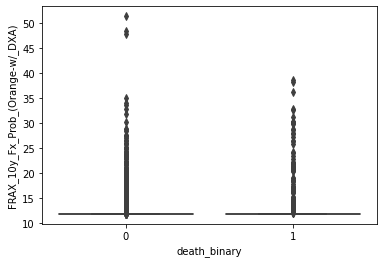

FRAX_10y_Hip_Fx_Prob_(Orange-w/_DXA)


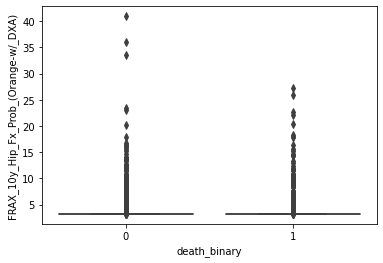

Met_Sx


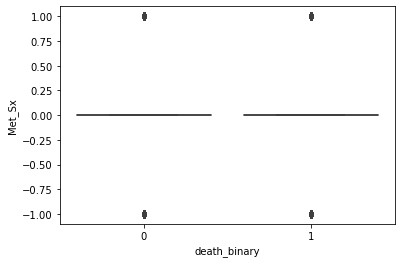

days


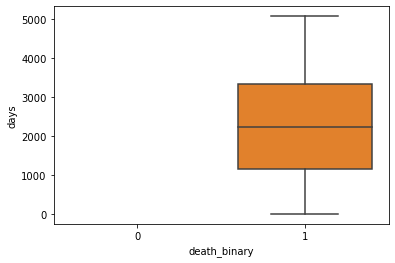

CVD


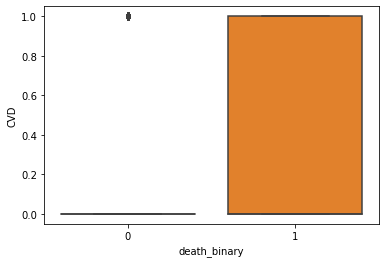

Heart_failure


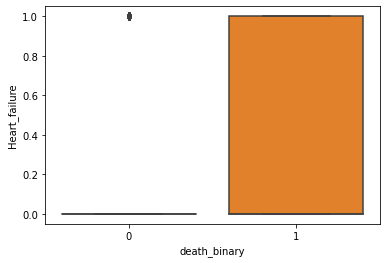

MI


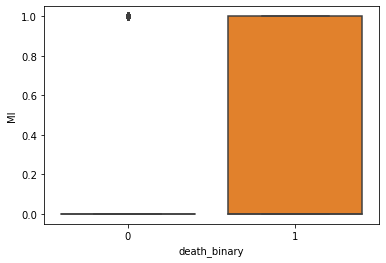

diabetes


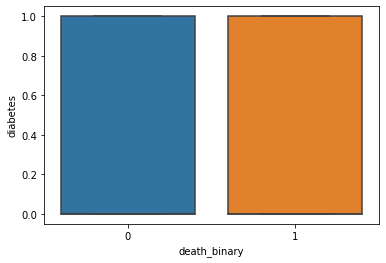

L1_HU_BMD


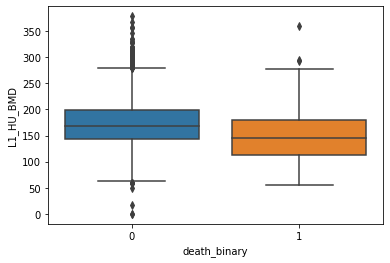

TAT_Area_(cm2)


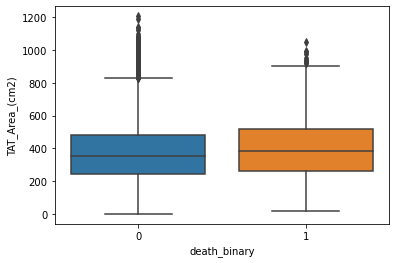

Total_Body_Area_EA_(cm2)


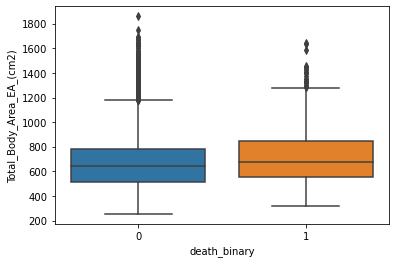

TAT/Body_Area


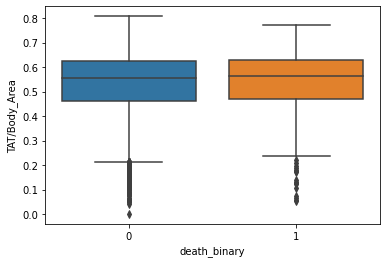

VAT_Area_(cm2)


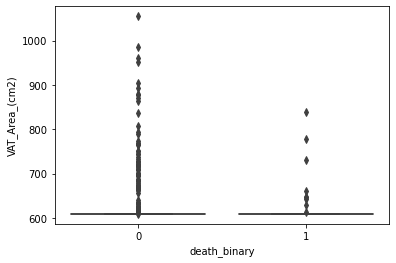

SAT_Area_(cm2)


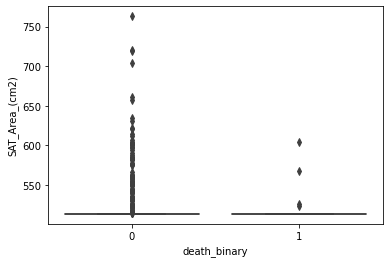

VAT/SAT_Ratio


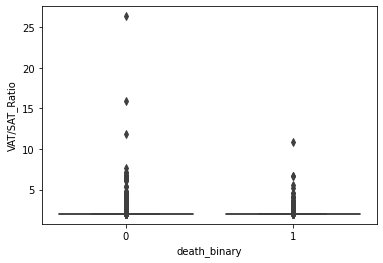

Muscle_HU


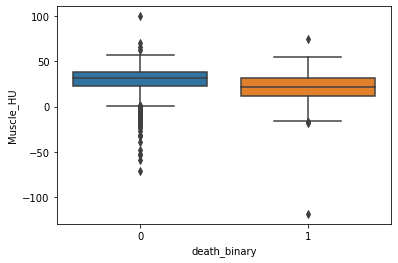

Muscle_Area_(cm2)


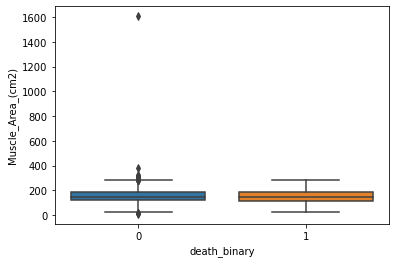

L3_SMI_(cm2/m2)


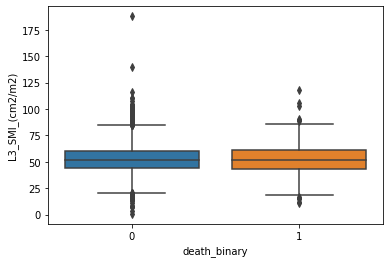

AoCa_Agatston


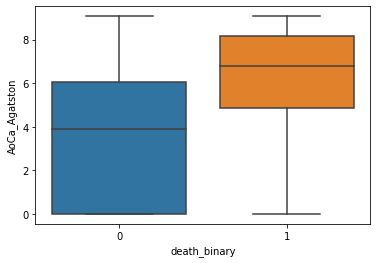

Liver_HU_(Median)


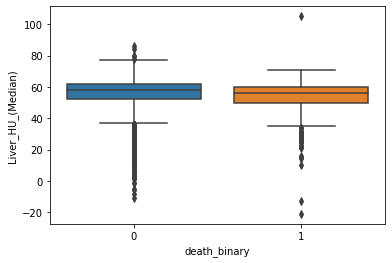

death_binary


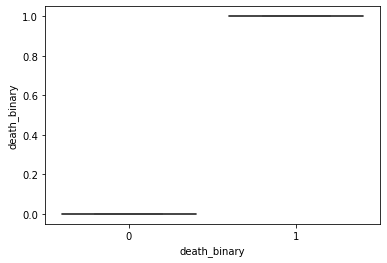

In [6]:
import seaborn as sns
for col in data.columns:
    print(col)
    sns.boxplot(x='death_binary', y=col, data=data)
    plt.show()

In [7]:
# ### Take non null values
# data = data[~data['days'].isna()]
# train_idx = pd.read_csv('Patients(RECORD_ID)TrainData.csv')['Record_ID']
# test_idx = pd.read_csv('Patients(RECORD_ID)_TestData.csv')['Record_ID']
# # print(train_idx)
# # train_idx = iter(train_idx)
# # test_idx = iter(test_idx)
# iterable = [train_idx, test_idx]

# feats = ['BMI', 'BMI_more_than_30',
#        'Sex', 'Age_at_CT', 'Tobacco', 'Alcohol_abuse', 'FRS_10-year_risk_(%)',
#        'FRAX_10y_Fx_Prob_(Orange-w/_DXA)','FRAX_10y_Hip_Fx_Prob_(Orange-w/_DXA)', 'Met_Sx', 'CVD',
#        'Heart_failure', 'MI', 'diabetes', 'L1_HU_BMD', 'TAT_Area_(cm2)',
#        'Total_Body_Area_EA_(cm2)', 'TAT/Body_Area', 'VAT_Area_(cm2)',
#        'SAT_Area_(cm2)', 'VAT/SAT_Ratio', 'Muscle_HU', 'Muscle_Area_(cm2)',
#        'L3_SMI_(cm2/m2)', 'AoCa_Agatston', 'Liver_HU_(Median)']

# label = 'days'

# train_scores, validation_scores = learning_curve(
# estimator = LinearRegression(),
# X = data[feats],
# y = data[label], cv = train_idx, cv = test_idx,
# scoring = 'neg_mean_squared_error')

In [8]:
train_idx = pd.read_csv('Patients(RECORD_ID)TrainData.csv')['Record_ID']
test_idx = pd.read_csv('Patients(RECORD_ID)_TestData.csv')['Record_ID']
train = data[data['Record_ID'].isin(train_idx)]
test = data[data['Record_ID'].isin(test_idx)]
print(train.shape)
print(test.shape)

(7363, 30)
(1860, 30)


In [9]:
# Train on Non-Null values
train = train[~train['days'].isna()]
val = test[~test['days'].isna()]
print(train.shape)

(419, 30)


In [10]:
all_feats = ['BMI', 'BMI_more_than_30',
       'Sex', 'Age_at_CT', 'Tobacco', 'Alcohol_abuse', 'FRS_10-year_risk_(%)',
       'FRAX_10y_Fx_Prob_(Orange-w/_DXA)','FRAX_10y_Hip_Fx_Prob_(Orange-w/_DXA)', 'Met_Sx', 'CVD',
       'Heart_failure', 'MI', 'diabetes', 'L1_HU_BMD', 'TAT_Area_(cm2)',
       'Total_Body_Area_EA_(cm2)', 'TAT/Body_Area', 'VAT_Area_(cm2)',
       'SAT_Area_(cm2)', 'VAT/SAT_Ratio', 'Muscle_HU', 'Muscle_Area_(cm2)',
       'L3_SMI_(cm2/m2)', 'AoCa_Agatston', 'Liver_HU_(Median)']


ct_feats = ['L1_HU_BMD', 'TAT_Area_(cm2)',
       'Total_Body_Area_EA_(cm2)', 'TAT/Body_Area', 'VAT_Area_(cm2)',
       'SAT_Area_(cm2)', 'VAT/SAT_Ratio', 'Muscle_HU', 'Muscle_Area_(cm2)',
       'L3_SMI_(cm2/m2)', 'AoCa_Agatston', 'Liver_HU_(Median)']

feats = all_feats
feats = [x for x in all_feats if x not in ct_feats]
#feats = ct_feats

label = 'days'
X_train = train[feats].values
Y_train = train[label].values
X_val = val[feats].values
Y_val = val[label].values
X_test = test[feats].values
Y_test = test[label].values
print(X_test.shape)
print(X_val.shape)
print(Y_val.shape)

(1860, 14)
(130, 14)
(130,)


In [11]:
eval_set = [(X_train, Y_train), (X_val, Y_val)]
model = xgb.XGBRegressor(n_estimators=500, max_depth=7, eta=0.01, subsample=1, colsample_bytree=1)
model.fit(X_train, Y_train, eval_metric='rmse', eval_set=eval_set)
# model = LinearRegression()
# model.fit(X_train, Y_train)

[0]	validation_0-rmse:2600.65991	validation_1-rmse:2598.99902
[1]	validation_0-rmse:2580.37061	validation_1-rmse:2579.80957
[2]	validation_0-rmse:2560.31982	validation_1-rmse:2560.76538
[3]	validation_0-rmse:2540.50439	validation_1-rmse:2542.07959
[4]	validation_0-rmse:2520.92310	validation_1-rmse:2523.49194
[5]	validation_0-rmse:2501.57251	validation_1-rmse:2505.23291
[6]	validation_0-rmse:2482.45068	validation_1-rmse:2487.24292
[7]	validation_0-rmse:2463.55591	validation_1-rmse:2469.35083
[8]	validation_0-rmse:2444.88574	validation_1-rmse:2451.88257
[9]	validation_0-rmse:2426.43799	validation_1-rmse:2434.46802
[10]	validation_0-rmse:2408.21094	validation_1-rmse:2417.39648
[11]	validation_0-rmse:2390.20898	validation_1-rmse:2400.42017
[12]	validation_0-rmse:2372.34131	validation_1-rmse:2384.22534
[13]	validation_0-rmse:2354.76221	validation_1-rmse:2367.83667
[14]	validation_0-rmse:2337.32642	validation_1-rmse:2351.89282
[15]	validation_0-rmse:2320.15479	validation_1-rmse:2335.88159
[1

[130]	validation_0-rmse:1214.02307	validation_1-rmse:1484.71997
[131]	validation_0-rmse:1208.81238	validation_1-rmse:1482.49206
[132]	validation_0-rmse:1203.72046	validation_1-rmse:1480.48523
[133]	validation_0-rmse:1198.55139	validation_1-rmse:1478.35632
[134]	validation_0-rmse:1193.57910	validation_1-rmse:1476.48767
[135]	validation_0-rmse:1188.68640	validation_1-rmse:1474.16357
[136]	validation_0-rmse:1183.74695	validation_1-rmse:1472.28381
[137]	validation_0-rmse:1178.82935	validation_1-rmse:1471.09705
[138]	validation_0-rmse:1173.08752	validation_1-rmse:1469.92578
[139]	validation_0-rmse:1168.09631	validation_1-rmse:1468.40015
[140]	validation_0-rmse:1163.42700	validation_1-rmse:1466.71533
[141]	validation_0-rmse:1158.30664	validation_1-rmse:1465.22375
[142]	validation_0-rmse:1152.79724	validation_1-rmse:1464.23950
[143]	validation_0-rmse:1148.82300	validation_1-rmse:1462.72400
[144]	validation_0-rmse:1143.40735	validation_1-rmse:1461.94116
[145]	validation_0-rmse:1139.53174	valid

[260]	validation_0-rmse:845.11688	validation_1-rmse:1397.40039
[261]	validation_0-rmse:843.79077	validation_1-rmse:1397.43347
[262]	validation_0-rmse:842.17279	validation_1-rmse:1397.63318
[263]	validation_0-rmse:840.84393	validation_1-rmse:1397.37256
[264]	validation_0-rmse:839.55090	validation_1-rmse:1397.39917
[265]	validation_0-rmse:837.88654	validation_1-rmse:1397.63354
[266]	validation_0-rmse:836.53381	validation_1-rmse:1397.78699
[267]	validation_0-rmse:835.20142	validation_1-rmse:1397.92175
[268]	validation_0-rmse:833.57141	validation_1-rmse:1398.16785
[269]	validation_0-rmse:832.30420	validation_1-rmse:1398.32581
[270]	validation_0-rmse:831.12317	validation_1-rmse:1398.33484
[271]	validation_0-rmse:829.30353	validation_1-rmse:1398.30786
[272]	validation_0-rmse:828.15418	validation_1-rmse:1398.37390
[273]	validation_0-rmse:826.98090	validation_1-rmse:1398.42602
[274]	validation_0-rmse:825.42334	validation_1-rmse:1398.71509
[275]	validation_0-rmse:824.30060	validation_1-rmse:139

[390]	validation_0-rmse:713.11322	validation_1-rmse:1408.23791
[391]	validation_0-rmse:712.30603	validation_1-rmse:1408.34570
[392]	validation_0-rmse:711.68146	validation_1-rmse:1408.42517
[393]	validation_0-rmse:710.91327	validation_1-rmse:1408.38489
[394]	validation_0-rmse:710.02673	validation_1-rmse:1408.61572
[395]	validation_0-rmse:709.46619	validation_1-rmse:1408.73511
[396]	validation_0-rmse:708.85687	validation_1-rmse:1408.81177
[397]	validation_0-rmse:707.98749	validation_1-rmse:1409.04285
[398]	validation_0-rmse:707.42358	validation_1-rmse:1409.20727
[399]	validation_0-rmse:706.60797	validation_1-rmse:1409.34119
[400]	validation_0-rmse:706.06634	validation_1-rmse:1409.46411
[401]	validation_0-rmse:705.26312	validation_1-rmse:1409.54834
[402]	validation_0-rmse:704.46491	validation_1-rmse:1409.63257
[403]	validation_0-rmse:703.92041	validation_1-rmse:1409.80005
[404]	validation_0-rmse:703.14050	validation_1-rmse:1409.88989
[405]	validation_0-rmse:702.36517	validation_1-rmse:141

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
             eta=0.01, gamma=0, gpu_id=-1, importance_type=None,
             interaction_constraints='', learning_rate=0.00999999978,
             max_delta_step=0, max_depth=7, min_child_weight=1, missing=nan,
             monotone_constraints='()', n_estimators=500, n_jobs=8,
             num_parallel_tree=1, predictor='auto', random_state=0, reg_alpha=0,
             reg_lambda=1, scale_pos_weight=1, subsample=1, tree_method='exact',
             validate_parameters=1, verbosity=None)

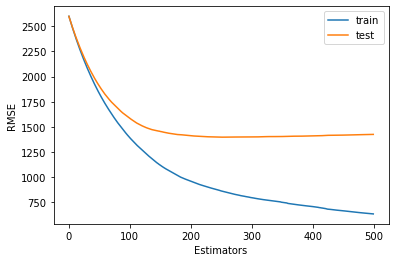

In [12]:
results = model.evals_result()
plt.plot(results['validation_0']['rmse'], label='train')
plt.plot(results['validation_1']['rmse'], label='test')
plt.legend()
plt.xlabel('Estimators')
plt.ylabel('RMSE')
plt.show()

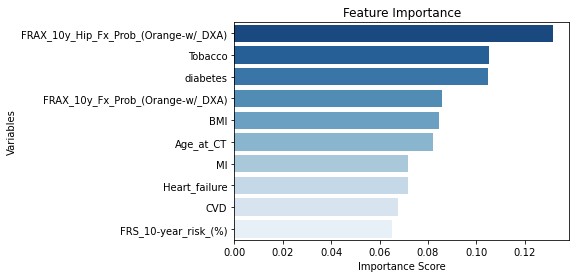

In [13]:
variables_df = pd.DataFrame(feats, columns=['Variables'])
importance_score_df = pd.DataFrame(model.feature_importances_, columns=['Importance Score'])

# print(variables_df)
# print(importance_score_df)

feature_imp = pd.concat([variables_df, importance_score_df], axis=1)
feature_imp = feature_imp.sort_values(by='Importance Score', ascending=False)
feature_imp = feature_imp.reset_index()
x = 'Importance Score'
y = 'Variables'
sns.barplot(x=x, y=y, data=feature_imp[:10], orient="h", palette="Blues_r")
plt.title('Feature Importance')
plt.show()

1424.7932128400423 2251.4153846153845
(130,)


<AxesSubplot:xlabel='Y_test', ylabel='preds'>

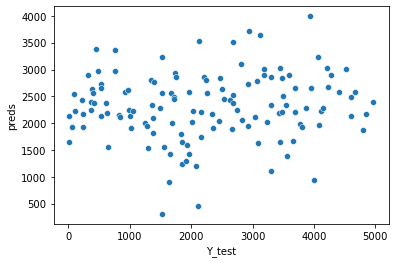

In [14]:
preds = model.predict(X_val)
rmse = math.sqrt(mean_squared_error(Y_val, preds))
print(rmse, Y_val.mean())

print(Y_val.shape)
tmp = {'Y_test':Y_val,'preds':preds} 
tmp_df = pd.DataFrame(tmp)
tmp_df.sort_values(by='Y_test', inplace=True)
sns.scatterplot(data=tmp_df, x='Y_test', y='preds')
# print(Y_val.shape)

                 0
count   130.000000
mean   2312.152832
std     620.043030
min     306.242218
25%    1969.287231
50%    2288.667847
75%    2669.763428
max    3992.376953
                 0
count  1730.000000
mean   2240.124268
std     527.612244
min     299.548981
25%    1921.935791
50%    2240.224609
75%    2578.123474
max    4259.574219
                 0
count  1860.000000
mean   2245.158691
std     534.718079
min     299.548981
25%    1927.396301
50%    2241.794556
75%    2583.252441
max    4259.574219
Error% for Non-zero values: 0.6328


<AxesSubplot:xlabel='Y_test_cat', ylabel='preds'>

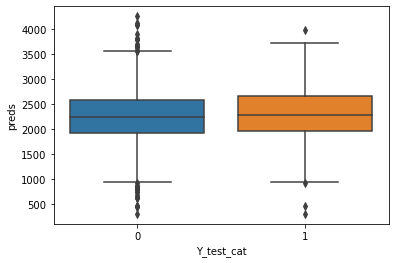

In [15]:
# Prediting on Null values

test_null = test[test['days'].isna()]
X_test_null = test_null[feats].values
preds_test_null = model.predict(X_test_null)

tmp_df = pd.DataFrame(preds)
print(tmp_df.describe())
tmp_df = pd.DataFrame(preds_test_null)
print(tmp_df.describe())

all_preds = model.predict(X_test)
tmp_df = pd.DataFrame(all_preds)
print(tmp_df.describe())


tmp = {'Y_test':Y_test,'preds':all_preds}
tmp_df = pd.DataFrame(tmp)
y_nz = tmp_df[~tmp_df['Y_test'].isna()]['Y_test']
preds_nz = tmp_df[~tmp_df['Y_test'].isna()]['preds']
rmse = math.sqrt(mean_squared_error(y_nz, preds_nz))
print("Error% for Non-zero values: {:0.4f}".format((rmse/y_nz.mean())))
 

tmp_df['Y_test_cat'] = np.where(tmp_df['Y_test'].isna(), 0, 1)
sns.boxplot(data=tmp_df, x='Y_test_cat', y='preds')

/opt/homebrew/Caskroom/miniforge/base/envs/pytorch_env/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


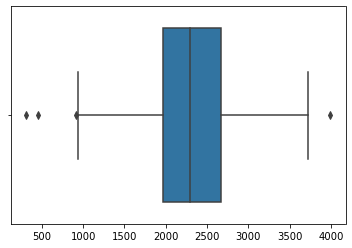

/opt/homebrew/Caskroom/miniforge/base/envs/pytorch_env/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


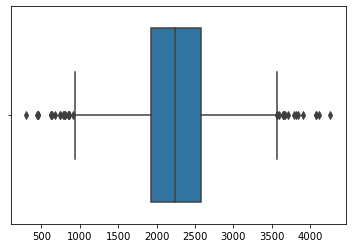

/opt/homebrew/Caskroom/miniforge/base/envs/pytorch_env/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:>

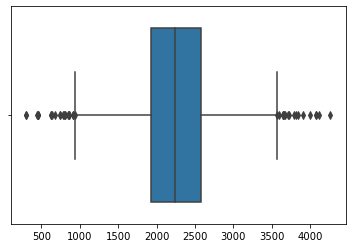

In [16]:
sns.boxplot(preds)
plt.show()
sns.boxplot(preds_test_null)
plt.show()
sns.boxplot(all_preds)

# Diabetes

In [17]:
data = orig_data.copy()

data['BMI_>30'] = np.where(data['BMI_>30']=='Y', 1, 0)
data.rename(columns={'BMI_>30':'BMI_more_than_30'}, inplace=True)
data['Sex'] = np.where(data['Sex']=='Male', 1, 0)
data['Tobacco'] = np.where(data['Tobacco']=='Yes', 1, 0)

data['Alcohol_abuse'] = np.where(data['Alcohol_abuse'].isna(),0,1)

col = 'FRS_10-year_risk_(%)'
data[col] = data[col].astype(str)
data[col] = data[col].str.replace('X','')
data[col] = data[col].str.replace('<1%',str(np.random.uniform(0, 0.01)))
data[col] = data[col].str.replace('>30%',str(np.random.uniform(0.3, 0.99)))
data[col] = pd.to_numeric(data[col], errors='coerce')
data[col] = data[col].astype(float)
med = data[col].median()
data[col] = data[col].fillna(med)
upper_limit = data[col].quantile(0.99)
data[col] = data[col].clip(upper_limit)

for col in ['FRAX_10y_Fx_Prob_(Orange-w/_DXA)','FRAX_10y_Hip_Fx_Prob_(Orange-w/_DXA)']:
    data[col] = data[col].astype(str)
    data[col] = data[col].str.replace('_','')
    data[col] = pd.to_numeric(data[col], errors='coerce')
    data[col] = data[col].astype(float)
    med = data[col].median()
    data[col] = data[col].fillna(med)
    upper_limit = data[col].quantile(0.95)
    data[col] = data[col].clip(upper_limit)

data['Met_Sx'] = np.where(data['Met_Sx']=='Y', 1, np.where(data['Met_Sx']=='N', 0, -1))


data['CVD'] = np.where(data['CVD_DX'].isna(),0,1)
data['MI'] = np.where(data['MI_DX'].isna(),0,1)
data['Heart_failure'] = np.where(data['Heart_failure_DX'].isna(),0,1)

data['days'] = data['Type_2_Diabetes_DX_Date_[d_from_CT]']
data['diabetes'] = np.where(data['Type_2_Diabetes_DX'].isna(), 0, 1)

data['L1_HU_BMD'] = data['L1_HU_BMD'].clip(lower=0)
data['TAT/Body_Area'] = data['TAT_Area_(cm2)']/data['Total_Body_Area_EA_(cm2)']
col = 'VAT_Area_(cm2)'
upper_limit = data[col].quantile(0.99)
data[col] = data[col].clip(upper_limit)
col = 'SAT_Area_(cm2)'
upper_limit = data[col].quantile(0.99)
data[col] = data[col].clip(upper_limit)
col = 'VAT/SAT_Ratio'
upper_limit = data[col].quantile(0.95)
data[col] = data[col].clip(upper_limit)

data['AoCa_Agatston'] = data['AoCa_Agatston'].clip(upper=data['AoCa_Agatston'].quantile(0.99))
data['AoCa_Agatston'] = data['AoCa_Agatston'].fillna(data['AoCa_Agatston'].median())
data['AoCa_Agatston'] = np.log(data['AoCa_Agatston']+1)

data['Liver_HU_(Median)'] = pd.to_numeric(data['Liver_HU_(Median)'], errors='coerce')
data['Liver_HU_(Median)'] = data['Liver_HU_(Median)'].astype(float)
data['Liver_HU_(Median)'] = data['Liver_HU_(Median)'].fillna(data['Liver_HU_(Median)'].median())
                          
for col in ['BMI','TAT_Area_(cm2)', 'Total_Body_Area_EA_(cm2)', 'VAT_Area_(cm2)','SAT_Area_(cm2)',
            'Muscle_Area_(cm2)','TAT/Body_Area']:
    data[col] = data[col].fillna(data[col].median())


### Below features filled by iterative imputing
# 'L1_HU_BMD'
# 'VAT/SAT_Ratio'
# 'Muscle_HU'
# L3_SMI_(cm2/m2)
# Liver_HU_(Median)

impute_it = IterativeImputer()

col = 'L1_HU_BMD'
# ind = data.index[data[col].isna()].tolist()
#print(len(data.loc[data[col] < 100, col]))
#print(data.loc[data[col].isna(), 'L1_HU_BMD'])
rel_cols = ['Age_at_CT', 'Muscle_HU', 'L1_HU_BMD']
X = data[rel_cols]
X = impute_it.fit_transform(X)
# print(X[:, 2])
data[col] = X[:, 2]
# print(col, data[col].isna().sum())

### VAT/SAT ratio -- Muscle area, Sex

col = 'VAT/SAT_Ratio'
rel_cols = ['Muscle_Area_(cm2)', 'Sex', col]
X = data[rel_cols]
X = impute_it.fit_transform(X)
data[col] = X[:,2]


col = 'Muscle_HU'
rel_cols = ['Age_at_CT', 'TAT/Body_Area', col]
X = data[rel_cols]
X = impute_it.fit_transform(X)
data[col] = X[:,2]

col = 'L3_SMI_(cm2/m2)'
rel_cols = ['BMI_more_than_30', 'Sex', col]
X = data[rel_cols]
X = impute_it.fit_transform(X)
data[col] = X[:,2]
                       

col = 'Liver_HU_(Median)'                                     
rel_cols = ['BMI_more_than_30', 'TAT/Body_Area', col]
X = data[rel_cols]
X = impute_it.fit_transform(X)
data[col] = X[:,2]
# for col in ['BMI','L1_HU_BMD','TAT_Area_(cm2)', 'Total_Body_Area_EA_(cm2)', 'VAT_Area_(cm2)','SAT_Area_(cm2)',
#             'VAT/SAT_Ratio','Muscle_HU','Muscle_Area_(cm2)','L3_SMI_(cm2/m2)','TAT/Body_Area']:
#     data[col] = data[col].fillna(data[col].median())

In [18]:
# cols = ['Record_ID', 'Clinical_F/U_interval_[d_from_CT]', 'BMI', 'BMI_>30', 'Sex', 'Age_at_CT', 'Tobacco', 'Alcohol_abuse',
#        'FRS_10-year_risk_(%)', 'FRAX_10y_Fx_Prob_(Orange-w/_DXA)',
#        'FRAX_10y_Hip_Fx_Prob_(Orange-w/_DXA)', 'Met_Sx',
#        'days', 'CVD', 'CVD_DX_Date_[d_from_CT]',
#        'Heart_failure', 'Heart_failure_DX_Date_[d_from_CT]', 'MI',
#        'MI_DX_Date_[d_from_CT]', 'diabetes',
#        'Type_2_Diabetes_DX_Date_[d_from_CT]', 'Femoral_neck_fracture_DX',
#        'Femoral_neck_fracture_DX_Date_[d_from_CT]',
#        'Unspec_femoral_fracture_DX',
#        'Unspec_femoral_fracture_DX_Date_[d_from_CT]', 'Forearm_fracture_DX',
#        'Forearm_fracture_DX_Date_[d_from_CT]', 'Humerus_fracture_DX',
#        'Humerus_fracture_DX_Date_[d_from_CT]', 'Pathologic_fracture_DX',
#        'Pathologic_fracture_DX_Date_[d_from_CT]', 'Alzheimers_DX',
#        'Alzheimers_DX_Date_[d_from_CT]', 'Primary_Cancer_Site',
#        'Primary_Cancer_Dx_[d_from_CT]', 'Primary_Cancer_Site_2',
#        'Primary_Cancer_Site_2_Dx_[d_from_CT]', 'L1_HU_BMD',
#        'TAT_Area_(cm2)', 'Total_Body_Area_EA_(cm2)', 'TAT/Body_Area', 'VAT_Area_(cm2)',
#        'SAT_Area_(cm2)', 'VAT/SAT_Ratio', 'Muscle_HU', 'Muscle_Area_(cm2)',
#        'L3_SMI_(cm2/m2)', 'AoCa_Agatston', 'Liver_HU_(Median)']

cols = ['Record_ID', 'BMI', 'BMI_more_than_30', 'Sex', 'Age_at_CT', 'Tobacco', 'Alcohol_abuse',
       'FRS_10-year_risk_(%)', 'FRAX_10y_Fx_Prob_(Orange-w/_DXA)',
       'FRAX_10y_Hip_Fx_Prob_(Orange-w/_DXA)', 'Met_Sx',
       'days', 'CVD', 'Heart_failure', 'MI', 'L1_HU_BMD',
       'TAT_Area_(cm2)', 'Total_Body_Area_EA_(cm2)', 'TAT/Body_Area', 'VAT_Area_(cm2)',
       'SAT_Area_(cm2)', 'VAT/SAT_Ratio', 'Muscle_HU', 'Muscle_Area_(cm2)',
       'L3_SMI_(cm2/m2)', 'AoCa_Agatston', 'Liver_HU_(Median)']

data = data[cols].copy()
print(data.isna().sum())

Record_ID                                  0
BMI                                        0
BMI_more_than_30                           0
Sex                                        0
Age_at_CT                                  0
Tobacco                                    0
Alcohol_abuse                              0
FRS_10-year_risk_(%)                       0
FRAX_10y_Fx_Prob_(Orange-w/_DXA)           0
FRAX_10y_Hip_Fx_Prob_(Orange-w/_DXA)       0
Met_Sx                                     0
days                                    6687
CVD                                        0
Heart_failure                              0
MI                                         0
L1_HU_BMD                                  0
TAT_Area_(cm2)                             0
Total_Body_Area_EA_(cm2)                   0
TAT/Body_Area                              0
VAT_Area_(cm2)                             0
SAT_Area_(cm2)                             0
VAT/SAT_Ratio                              0
Muscle_HU 

In [19]:
train_idx = pd.read_csv('Patients(RECORD_ID)TrainData.csv')['Record_ID']
test_idx = pd.read_csv('Patients(RECORD_ID)_TestData.csv')['Record_ID']
train = data[data['Record_ID'].isin(train_idx)]
test = data[data['Record_ID'].isin(test_idx)]
print(train.shape)
print(test.shape)

(7363, 27)
(1860, 27)


In [139]:
# Train on Non-Null values
train = train[~train['days'].isna()]
val = test[~test['days'].isna()]
print(train.shape)
print(val.shape)

(2035, 27)
(501, 27)


In [140]:
feats = ['BMI', 'BMI_more_than_30', 'Sex', 'Age_at_CT', 'Tobacco', 'Alcohol_abuse',
       'FRS_10-year_risk_(%)', 'FRAX_10y_Fx_Prob_(Orange-w/_DXA)',
       'FRAX_10y_Hip_Fx_Prob_(Orange-w/_DXA)', 'Met_Sx',
        'CVD', 'Heart_failure', 'MI', 'L1_HU_BMD',
       'TAT_Area_(cm2)', 'Total_Body_Area_EA_(cm2)', 'TAT/Body_Area', 'VAT_Area_(cm2)',
       'SAT_Area_(cm2)', 'VAT/SAT_Ratio', 'Muscle_HU', 'Muscle_Area_(cm2)',
       'L3_SMI_(cm2/m2)', 'AoCa_Agatston', 'Liver_HU_(Median)']

label = 'days'
X_train = train[feats].values
Y_train = train[label].values
X_val = val[feats].values
Y_val = val[label].values

In [141]:
eval_set = [(X_train, Y_train), (X_val, Y_val)]
# model = xgb.XGBRegressor(n_estimators=250, max_depth=7, eta=0.01, subsample=1, colsample_bytree=1)
# model.fit(X_train, Y_train, eval_metric='rmse', eval_set=eval_set)

model = LinearRegression()
model.fit(X_train, Y_train)

LinearRegression()

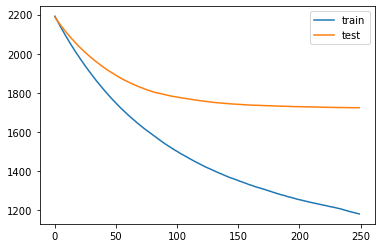

In [129]:
results = model.evals_result()
plt.plot(results['validation_0']['rmse'], label='train')
plt.plot(results['validation_1']['rmse'], label='test')
plt.legend()
plt.show()

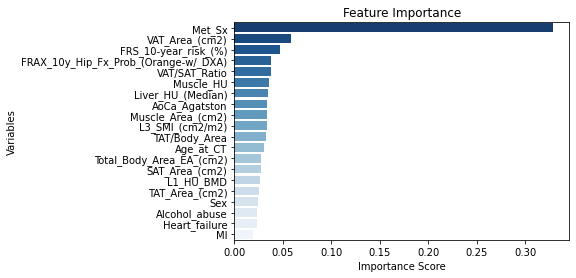

In [130]:
variables_df = pd.DataFrame(feats, columns=['Variables'])
importance_score_df = pd.DataFrame(model.feature_importances_, columns=['Importance Score'])
feature_imp = pd.concat([variables_df, importance_score_df], axis=1)
feature_imp = feature_imp.sort_values(by='Importance Score', ascending=False)
feature_imp = feature_imp.reset_index()
x = 'Importance Score'
y = 'Variables'
sns.barplot(x=x, y=y, data=feature_imp[:20], orient="h", palette="Blues_r")
plt.title('Feature Importance')
plt.show()

rmse= 1750.1438076368522 Y_val mean= 1127.566866267465


<AxesSubplot:xlabel='Y_test', ylabel='preds'>

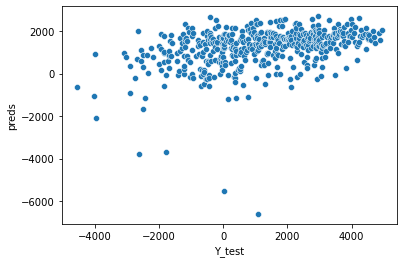

In [142]:
preds = model.predict(X_val)
rmse = math.sqrt(mean_squared_error(Y_val, preds))
print("rmse=", rmse, "Y_val mean=", Y_val.mean())

tmp = {'Y_test':Y_val,'preds':preds} 
tmp_df = pd.DataFrame(tmp)
tmp_df.sort_values(by='Y_test', inplace=True)
sns.scatterplot(data=tmp_df, x='Y_test', y='preds')

In [143]:
# Prediting on Null values

test_null = test[test['days'].isna()]
X_test_null = test_null[feats].values
preds_test_null = model.predict(X_test_null)

tmp_df = pd.DataFrame(preds)
print(tmp_df.describe())
tmp_df = pd.DataFrame(preds_test_null)
print(tmp_df.describe())

                 0
count   501.000000
mean   1203.864194
std     950.646954
min   -6610.859938
25%     818.916405
50%    1422.695763
75%    1780.028931
max    2693.738969
                 0
count  1359.000000
mean   1656.414149
std     540.612500
min   -1883.159088
25%    1456.627665
50%    1724.277326
75%    1965.614080
max    3137.047906


/opt/homebrew/Caskroom/miniforge/base/envs/pytorch_env/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


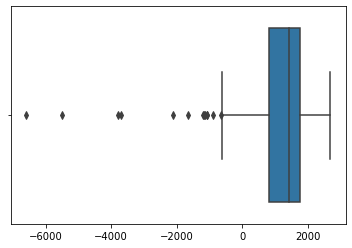

/opt/homebrew/Caskroom/miniforge/base/envs/pytorch_env/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:>

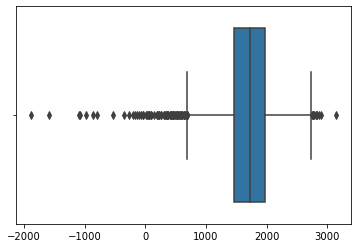

In [144]:
sns.boxplot(preds)
plt.show()
sns.boxplot(preds_test_null)

In [135]:
preds_test_null.shape

(1359,)

In [104]:
extra = preds_test_null.shape[0] - preds.shape[0]
null_array = np.empty(extra)
preds_concat = np.concatenate((preds, null_array), axis=0)

tmp_df = pd.DataFrame({'preds_test_null':preds_test_null})
tmp_df['preds'] = preds_concat

# Heart Attack

In [64]:
data = orig_data.copy()

data['BMI_>30'] = np.where(data['BMI_>30']=='Y', 1, 0)
data.rename(columns={'BMI_>30':'BMI_more_than_30'}, inplace=True)
data['Sex'] = np.where(data['Sex']=='Male', 1, 0)
data['Tobacco'] = np.where(data['Tobacco']=='Yes', 1, 0)

data['Alcohol_abuse'] = np.where(data['Alcohol_abuse'].isna(),0,1)

col = 'FRS_10-year_risk_(%)'
data[col] = data[col].astype(str)
data[col] = data[col].str.replace('X','')
data[col] = data[col].str.replace('<1%',str(np.random.uniform(0, 0.01)))
data[col] = data[col].str.replace('>30%',str(np.random.uniform(0.3, 0.99)))
data[col] = pd.to_numeric(data[col], errors='coerce')
data[col] = data[col].astype(float)
med = data[col].median()
data[col] = data[col].fillna(med)
upper_limit = data[col].quantile(0.99)
data[col] = data[col].clip(upper_limit)

for col in ['FRAX_10y_Fx_Prob_(Orange-w/_DXA)','FRAX_10y_Hip_Fx_Prob_(Orange-w/_DXA)']:
    data[col] = data[col].astype(str)
    data[col] = data[col].str.replace('_','')
    data[col] = pd.to_numeric(data[col], errors='coerce')
    data[col] = data[col].astype(float)
    med = data[col].median()
    data[col] = data[col].fillna(med)
    upper_limit = data[col].quantile(0.95)
    data[col] = data[col].clip(upper_limit)

data['Met_Sx'] = np.where(data['Met_Sx']=='Y', 1, np.where(data['Met_Sx']=='N', 0, -1))


data['CVD'] = np.where(data['CVD_DX'].isna(),0,1)
data['MI'] = np.where(data['MI_DX'].isna(),0,1)
data['Heart_failure'] = np.where(data['Heart_failure_DX'].isna(),0,1)

data['days'] = data['MI_DX_Date_[d_from_CT]']
data['diabetes'] = np.where(data['Type_2_Diabetes_DX'].isna(), 0, 1)

data['L1_HU_BMD'] = data['L1_HU_BMD'].clip(lower=0)
data['TAT/Body_Area'] = data['TAT_Area_(cm2)']/data['Total_Body_Area_EA_(cm2)']
col = 'VAT_Area_(cm2)'
upper_limit = data[col].quantile(0.99)
data[col] = data[col].clip(upper_limit)
col = 'SAT_Area_(cm2)'
upper_limit = data[col].quantile(0.99)
data[col] = data[col].clip(upper_limit)
col = 'VAT/SAT_Ratio'
upper_limit = data[col].quantile(0.95)
data[col] = data[col].clip(upper_limit)

data['AoCa_Agatston'] = data['AoCa_Agatston'].clip(upper=data['AoCa_Agatston'].quantile(0.99))
data['AoCa_Agatston'] = data['AoCa_Agatston'].fillna(data['AoCa_Agatston'].median())
data['AoCa_Agatston'] = np.log(data['AoCa_Agatston']+1)

data['Liver_HU_(Median)'] = pd.to_numeric(data['Liver_HU_(Median)'], errors='coerce')
data['Liver_HU_(Median)'] = data['Liver_HU_(Median)'].astype(float)
data['Liver_HU_(Median)'] = data['Liver_HU_(Median)'].fillna(data['Liver_HU_(Median)'].median())
                          
for col in ['BMI','TAT_Area_(cm2)', 'Total_Body_Area_EA_(cm2)', 'VAT_Area_(cm2)','SAT_Area_(cm2)',
            'Muscle_Area_(cm2)','TAT/Body_Area']:
    data[col] = data[col].fillna(data[col].median())


### Below features filled by iterative imputing
# 'L1_HU_BMD'
# 'VAT/SAT_Ratio'
# 'Muscle_HU'
# L3_SMI_(cm2/m2)
# Liver_HU_(Median)

impute_it = IterativeImputer()

col = 'L1_HU_BMD'
# ind = data.index[data[col].isna()].tolist()
#print(len(data.loc[data[col] < 100, col]))
#print(data.loc[data[col].isna(), 'L1_HU_BMD'])
rel_cols = ['Age_at_CT', 'Muscle_HU', 'L1_HU_BMD']
X = data[rel_cols]
X = impute_it.fit_transform(X)
# print(X[:, 2])
data[col] = X[:, 2]
# print(col, data[col].isna().sum())

### VAT/SAT ratio -- Muscle area, Sex

col = 'VAT/SAT_Ratio'
rel_cols = ['Muscle_Area_(cm2)', 'Sex', col]
X = data[rel_cols]
X = impute_it.fit_transform(X)
data[col] = X[:,2]


col = 'Muscle_HU'
rel_cols = ['Age_at_CT', 'TAT/Body_Area', col]
X = data[rel_cols]
X = impute_it.fit_transform(X)
data[col] = X[:,2]

col = 'L3_SMI_(cm2/m2)'
rel_cols = ['BMI_more_than_30', 'Sex', col]
X = data[rel_cols]
X = impute_it.fit_transform(X)
data[col] = X[:,2]
                       

col = 'Liver_HU_(Median)'                                     
rel_cols = ['BMI_more_than_30', 'TAT/Body_Area', col]
X = data[rel_cols]
X = impute_it.fit_transform(X)
data[col] = X[:,2]
# for col in ['BMI','L1_HU_BMD','TAT_Area_(cm2)', 'Total_Body_Area_EA_(cm2)', 'VAT_Area_(cm2)','SAT_Area_(cm2)',
#             'VAT/SAT_Ratio','Muscle_HU','Muscle_Area_(cm2)','L3_SMI_(cm2/m2)','TAT/Body_Area']:
#     data[col] = data[col].fillna(data[col].median())

In [65]:
# cols = ['Record_ID', 'Clinical_F/U_interval_[d_from_CT]', 'BMI', 'BMI_>30', 'Sex', 'Age_at_CT', 'Tobacco', 'Alcohol_abuse',
#        'FRS_10-year_risk_(%)', 'FRAX_10y_Fx_Prob_(Orange-w/_DXA)',
#        'FRAX_10y_Hip_Fx_Prob_(Orange-w/_DXA)', 'Met_Sx',
#        'days', 'CVD', 'CVD_DX_Date_[d_from_CT]',
#        'Heart_failure', 'Heart_failure_DX_Date_[d_from_CT]', 'MI',
#        'MI_DX_Date_[d_from_CT]', 'diabetes',
#        'Type_2_Diabetes_DX_Date_[d_from_CT]', 'Femoral_neck_fracture_DX',
#        'Femoral_neck_fracture_DX_Date_[d_from_CT]',
#        'Unspec_femoral_fracture_DX',
#        'Unspec_femoral_fracture_DX_Date_[d_from_CT]', 'Forearm_fracture_DX',
#        'Forearm_fracture_DX_Date_[d_from_CT]', 'Humerus_fracture_DX',
#        'Humerus_fracture_DX_Date_[d_from_CT]', 'Pathologic_fracture_DX',
#        'Pathologic_fracture_DX_Date_[d_from_CT]', 'Alzheimers_DX',
#        'Alzheimers_DX_Date_[d_from_CT]', 'Primary_Cancer_Site',
#        'Primary_Cancer_Dx_[d_from_CT]', 'Primary_Cancer_Site_2',
#        'Primary_Cancer_Site_2_Dx_[d_from_CT]', 'L1_HU_BMD',
#        'TAT_Area_(cm2)', 'Total_Body_Area_EA_(cm2)', 'TAT/Body_Area', 'VAT_Area_(cm2)',
#        'SAT_Area_(cm2)', 'VAT/SAT_Ratio', 'Muscle_HU', 'Muscle_Area_(cm2)',
#        'L3_SMI_(cm2/m2)', 'AoCa_Agatston', 'Liver_HU_(Median)']

cols = ['Record_ID', 'BMI', 'BMI_more_than_30', 'Sex', 'Age_at_CT', 'Tobacco', 'Alcohol_abuse',
       'FRS_10-year_risk_(%)', 'FRAX_10y_Fx_Prob_(Orange-w/_DXA)',
       'FRAX_10y_Hip_Fx_Prob_(Orange-w/_DXA)', 'Met_Sx', 'CVD',
       'Heart_failure', 'days', 'diabetes', 'L1_HU_BMD',
       'TAT_Area_(cm2)', 'Total_Body_Area_EA_(cm2)', 'TAT/Body_Area', 'VAT_Area_(cm2)',
       'SAT_Area_(cm2)', 'VAT/SAT_Ratio', 'Muscle_HU', 'Muscle_Area_(cm2)',
       'L3_SMI_(cm2/m2)', 'AoCa_Agatston', 'Liver_HU_(Median)']

data = data[cols].copy()
print(data.isna().sum())

Record_ID                                  0
BMI                                        0
BMI_more_than_30                           0
Sex                                        0
Age_at_CT                                  0
Tobacco                                    0
Alcohol_abuse                              0
FRS_10-year_risk_(%)                       0
FRAX_10y_Fx_Prob_(Orange-w/_DXA)           0
FRAX_10y_Hip_Fx_Prob_(Orange-w/_DXA)       0
Met_Sx                                     0
CVD                                        0
Heart_failure                              0
days                                    8382
diabetes                                   0
L1_HU_BMD                                  0
TAT_Area_(cm2)                             0
Total_Body_Area_EA_(cm2)                   0
TAT/Body_Area                              0
VAT_Area_(cm2)                             0
SAT_Area_(cm2)                             0
VAT/SAT_Ratio                              0
Muscle_HU 

In [66]:
train_idx = pd.read_csv('Patients(RECORD_ID)TrainData.csv')['Record_ID']
test_idx = pd.read_csv('Patients(RECORD_ID)_TestData.csv')['Record_ID']
train = data[data['Record_ID'].isin(train_idx)]
test = data[data['Record_ID'].isin(test_idx)]
print(train.shape)
print(test.shape)

(7363, 27)
(1860, 27)


In [67]:
# Train on Non-Null values
train = train[~train['days'].isna()]
val = test[~test['days'].isna()]
print(train.shape)
print(val.shape)

(662, 27)
(179, 27)


In [68]:
feats = ['BMI', 'BMI_more_than_30',
       'Sex', 'Age_at_CT', 'Tobacco', 'Alcohol_abuse', 'FRS_10-year_risk_(%)',
       'FRAX_10y_Fx_Prob_(Orange-w/_DXA)','FRAX_10y_Hip_Fx_Prob_(Orange-w/_DXA)', 'Met_Sx', 'CVD',
       'Heart_failure', 'diabetes', 'L1_HU_BMD', 'TAT_Area_(cm2)',
       'Total_Body_Area_EA_(cm2)', 'TAT/Body_Area', 'VAT_Area_(cm2)',
       'SAT_Area_(cm2)', 'VAT/SAT_Ratio', 'Muscle_HU', 'Muscle_Area_(cm2)',
       'L3_SMI_(cm2/m2)', 'AoCa_Agatston', 'Liver_HU_(Median)']

label = 'days'
X_train = train[feats].values
Y_train = train[label].values
X_val = val[feats].values
Y_val = val[label].values

In [69]:
eval_set = [(X_train, Y_train), (X_val, Y_val)]
# model = xgb.XGBRegressor(n_estimators=250, max_depth=7, eta=0.01, subsample=1, colsample_bytree=1)
# model.fit(X_train, Y_train, eval_metric='rmse', eval_set=eval_set)

model = LinearRegression()
model.fit(X_train, Y_train)

LinearRegression()

In [70]:
results = model.evals_result()
plt.plot(results['validation_0']['rmse'], label='train')
plt.plot(results['validation_1']['rmse'], label='test')
plt.legend()
plt.show()

AttributeError: 'LinearRegression' object has no attribute 'evals_result'

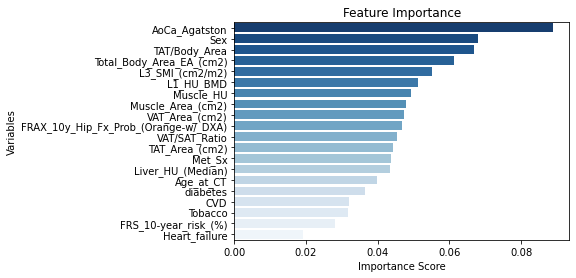

In [186]:
variables_df = pd.DataFrame(feats, columns=['Variables'])
importance_score_df = pd.DataFrame(model.feature_importances_, columns=['Importance Score'])
feature_imp = pd.concat([variables_df, importance_score_df], axis=1)
feature_imp = feature_imp.sort_values(by='Importance Score', ascending=False)
feature_imp = feature_imp.reset_index()
x = 'Importance Score'
y = 'Variables'
sns.barplot(x=x, y=y, data=feature_imp[:20], orient="h", palette="Blues_r")
plt.title('Feature Importance')
plt.show()

rmse= 1759.5125293348117 Y_val mean= 580.6480446927375


<AxesSubplot:xlabel='Y_test', ylabel='preds'>

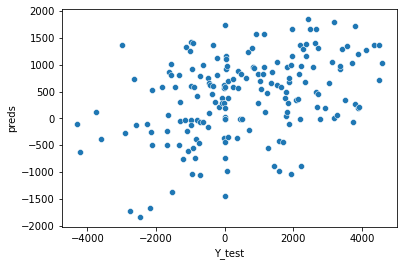

In [71]:
preds = model.predict(X_val)
rmse = math.sqrt(mean_squared_error(Y_val, preds))
print("rmse=", rmse, "Y_val mean=", Y_val.mean())

tmp = {'Y_test':Y_val,'preds':preds} 
tmp_df = pd.DataFrame(tmp)
tmp_df.sort_values(by='Y_test', inplace=True)
sns.scatterplot(data=tmp_df, x='Y_test', y='preds')

In [188]:
# Prediting on Null values

test_null = test[test['days'].isna()]
X_test_null = test_null[feats].values
preds_test_null = model.predict(X_test_null)

tmp_df = pd.DataFrame(preds)
print(tmp_df.describe())
tmp_df = pd.DataFrame(preds_test_null)
print(tmp_df.describe())

                 0
count   179.000000
mean    336.597076
std     712.772034
min   -1670.427246
25%    -138.650238
50%     324.607788
75%     794.674316
max    2571.449219
                 0
count  1681.000000
mean    815.637878
std     717.257141
min   -1592.254150
25%     326.537903
50%     810.831665
75%    1278.152344
max    2907.372559


/opt/homebrew/Caskroom/miniforge/base/envs/pytorch_env/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


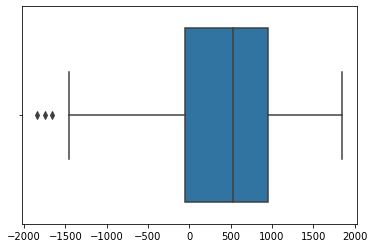

/opt/homebrew/Caskroom/miniforge/base/envs/pytorch_env/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:>

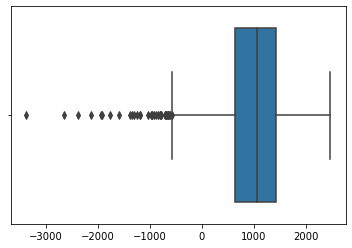

In [183]:
sns.boxplot(preds)
plt.show()
sns.boxplot(preds_test_null)

## Biological Age

In [173]:
data = orig_data.copy()

data['BMI_>30'] = np.where(data['BMI_>30']=='Y', 1, 0)
data.rename(columns={'BMI_>30':'BMI_more_than_30'}, inplace=True)
data['Sex'] = np.where(data['Sex']=='Male', 1, 0)
data['Tobacco'] = np.where(data['Tobacco']=='Yes', 1, 0)

data['Alcohol_abuse'] = np.where(data['Alcohol_abuse'].isna(),0,1)

col = 'FRS_10-year_risk_(%)'
data[col] = data[col].astype(str)
data[col] = data[col].str.replace('X','')
data[col] = data[col].str.replace('<1%',str(np.random.uniform(0, 0.01)))
data[col] = data[col].str.replace('>30%',str(np.random.uniform(0.3, 0.99)))
data[col] = pd.to_numeric(data[col], errors='coerce')
data[col] = data[col].astype(float)
med = data[col].median()
data[col] = data[col].fillna(med)
upper_limit = data[col].quantile(0.99)
data[col] = data[col].clip(upper_limit)

for col in ['FRAX_10y_Fx_Prob_(Orange-w/_DXA)','FRAX_10y_Hip_Fx_Prob_(Orange-w/_DXA)']:
    data[col] = data[col].astype(str)
    data[col] = data[col].str.replace('_','')
    data[col] = pd.to_numeric(data[col], errors='coerce')
    data[col] = data[col].astype(float)
    med = data[col].median()
    data[col] = data[col].fillna(med)
    upper_limit = data[col].quantile(0.95)
    data[col] = data[col].clip(upper_limit)

data['Met_Sx'] = np.where(data['Met_Sx']=='Y', 1, np.where(data['Met_Sx']=='N', 0, -1))


data['CVD'] = np.where(data['CVD_DX'].isna(),0,1)
data['MI'] = np.where(data['MI_DX'].isna(),0,1)
data['Heart_failure'] = np.where(data['Heart_failure_DX'].isna(),0,1)


max_bio_subtract = 80000
decay_rate = 0.0001
max_bio_age = 100

data['Decay_Days'] = 18 + max_bio_subtract*(1 - np.exp(-decay_rate*data['DEATH_[d_from_CT]']))
data['Bio_Age_AT_CT[DAYS]'] = max_bio_age*365 - data['Decay_Days']


data['days'] = data['Bio_Age_AT_CT[DAYS]']

data['diabetes'] = np.where(data['Type_2_Diabetes_DX'].isna(), 0, 1)

data['L1_HU_BMD'] = data['L1_HU_BMD'].clip(lower=0)
data['TAT/Body_Area'] = data['TAT_Area_(cm2)']/data['Total_Body_Area_EA_(cm2)']
col = 'VAT_Area_(cm2)'
upper_limit = data[col].quantile(0.99)
data[col] = data[col].clip(upper_limit)
col = 'SAT_Area_(cm2)'
upper_limit = data[col].quantile(0.99)
data[col] = data[col].clip(upper_limit)
col = 'VAT/SAT_Ratio'
upper_limit = data[col].quantile(0.95)
data[col] = data[col].clip(upper_limit)

data['AoCa_Agatston'] = data['AoCa_Agatston'].clip(upper=data['AoCa_Agatston'].quantile(0.99))
data['AoCa_Agatston'] = data['AoCa_Agatston'].fillna(data['AoCa_Agatston'].median())
data['AoCa_Agatston'] = np.log(data['AoCa_Agatston']+1)

data['Liver_HU_(Median)'] = pd.to_numeric(data['Liver_HU_(Median)'], errors='coerce')
data['Liver_HU_(Median)'] = data['Liver_HU_(Median)'].astype(float)
#data['Liver_HU_(Median)'] = data['Liver_HU_(Median)'].fillna(data['Liver_HU_(Median)'].median())
                          
for col in ['BMI','TAT_Area_(cm2)', 'Total_Body_Area_EA_(cm2)', 'VAT_Area_(cm2)','SAT_Area_(cm2)',
            'Muscle_Area_(cm2)','TAT/Body_Area']:
    data[col] = data[col].fillna(data[col].median())


### Below features filled by iterative imputing
# 'L1_HU_BMD'
# 'VAT/SAT_Ratio'
# 'Muscle_HU'
# L3_SMI_(cm2/m2)
# Liver_HU_(Median)

impute_it = IterativeImputer()

col = 'L1_HU_BMD'
# ind = data.index[data[col].isna()].tolist()
#print(len(data.loc[data[col] < 100, col]))
#print(data.loc[data[col].isna(), 'L1_HU_BMD'])
rel_cols = ['Age_at_CT', 'Muscle_HU', 'L1_HU_BMD']
X = data[rel_cols]
X = impute_it.fit_transform(X)
# print(X[:, 2])
data[col] = X[:, 2]
# print(col, data[col].isna().sum())

### VAT/SAT ratio -- Muscle area, Sex

col = 'VAT/SAT_Ratio'
rel_cols = ['Muscle_Area_(cm2)', 'Sex', col]
X = data[rel_cols]
X = impute_it.fit_transform(X)
data[col] = X[:,2]


col = 'Muscle_HU'
rel_cols = ['Age_at_CT', 'TAT/Body_Area', col]
X = data[rel_cols]
X = impute_it.fit_transform(X)
data[col] = X[:,2]

col = 'L3_SMI_(cm2/m2)'
rel_cols = ['BMI_more_than_30', 'Sex', col]
X = data[rel_cols]
X = impute_it.fit_transform(X)
data[col] = X[:,2]
                       

col = 'Liver_HU_(Median)'                                     
rel_cols = ['BMI_more_than_30', 'TAT/Body_Area', col]
X = data[rel_cols]
X = impute_it.fit_transform(X)
data[col] = X[:,2]


In [174]:
# cols = ['Record_ID', 'Clinical_F/U_interval_[d_from_CT]', 'BMI', 'BMI_>30', 'Sex', 'Age_at_CT', 'Tobacco', 'Alcohol_abuse',
#        'FRS_10-year_risk_(%)', 'FRAX_10y_Fx_Prob_(Orange-w/_DXA)',
#        'FRAX_10y_Hip_Fx_Prob_(Orange-w/_DXA)', 'Met_Sx',
#        'days', 'CVD', 'CVD_DX_Date_[d_from_CT]',
#        'Heart_failure', 'Heart_failure_DX_Date_[d_from_CT]', 'MI',
#        'MI_DX_Date_[d_from_CT]', 'diabetes',
#        'Type_2_Diabetes_DX_Date_[d_from_CT]', 'Femoral_neck_fracture_DX',
#        'Femoral_neck_fracture_DX_Date_[d_from_CT]',
#        'Unspec_femoral_fracture_DX',
#        'Unspec_femoral_fracture_DX_Date_[d_from_CT]', 'Forearm_fracture_DX',
#        'Forearm_fracture_DX_Date_[d_from_CT]', 'Humerus_fracture_DX',
#        'Humerus_fracture_DX_Date_[d_from_CT]', 'Pathologic_fracture_DX',
#        'Pathologic_fracture_DX_Date_[d_from_CT]', 'Alzheimers_DX',
#        'Alzheimers_DX_Date_[d_from_CT]', 'Primary_Cancer_Site',
#        'Primary_Cancer_Dx_[d_from_CT]', 'Primary_Cancer_Site_2',
#        'Primary_Cancer_Site_2_Dx_[d_from_CT]', 'L1_HU_BMD',
#        'TAT_Area_(cm2)', 'Total_Body_Area_EA_(cm2)', 'TAT/Body_Area', 'VAT_Area_(cm2)',
#        'SAT_Area_(cm2)', 'VAT/SAT_Ratio', 'Muscle_HU', 'Muscle_Area_(cm2)',
#        'L3_SMI_(cm2/m2)', 'AoCa_Agatston', 'Liver_HU_(Median)']

cols = ['Record_ID', 'Clinical_F/U_interval_[d_from_CT]', 'BMI', 'BMI_more_than_30', 'Sex', 'Age_at_CT', 'Tobacco', 'Alcohol_abuse',
       'FRS_10-year_risk_(%)', 'FRAX_10y_Fx_Prob_(Orange-w/_DXA)',
       'FRAX_10y_Hip_Fx_Prob_(Orange-w/_DXA)', 'Met_Sx',
       'days', 'CVD', 'Heart_failure', 'MI', 'diabetes', 'L1_HU_BMD',
       'TAT_Area_(cm2)', 'Total_Body_Area_EA_(cm2)', 'TAT/Body_Area', 'VAT_Area_(cm2)',
       'SAT_Area_(cm2)', 'VAT/SAT_Ratio', 'Muscle_HU', 'Muscle_Area_(cm2)',
       'L3_SMI_(cm2/m2)', 'AoCa_Agatston', 'Liver_HU_(Median)']

#print(data['BMI_>30'])
data = data[cols].copy()
data['death_binary'] = np.where(data['days'].isna(),0,1)
print(data.isna().sum())

Record_ID                                  0
Clinical_F/U_interval_[d_from_CT]          0
BMI                                        0
BMI_more_than_30                           0
Sex                                        0
Age_at_CT                                  0
Tobacco                                    0
Alcohol_abuse                              0
FRS_10-year_risk_(%)                       0
FRAX_10y_Fx_Prob_(Orange-w/_DXA)           0
FRAX_10y_Hip_Fx_Prob_(Orange-w/_DXA)       0
Met_Sx                                     0
days                                    8674
CVD                                        0
Heart_failure                              0
MI                                         0
diabetes                                   0
L1_HU_BMD                                  0
TAT_Area_(cm2)                             0
Total_Body_Area_EA_(cm2)                   0
TAT/Body_Area                              0
VAT_Area_(cm2)                             0
SAT_Area_(

Record_ID


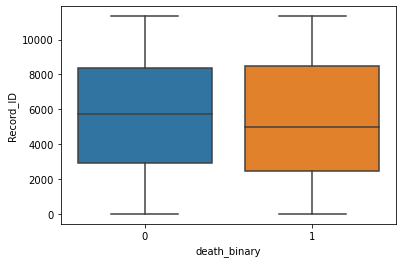

Clinical_F/U_interval_[d_from_CT]


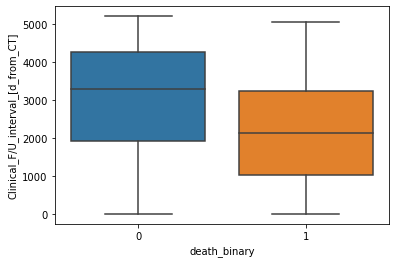

BMI


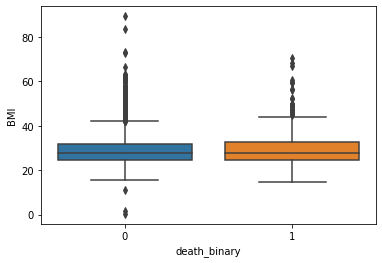

BMI_more_than_30


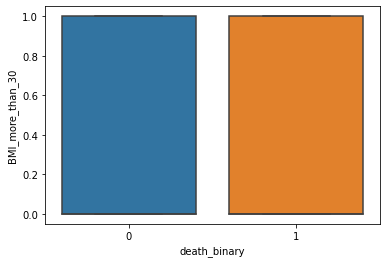

Sex


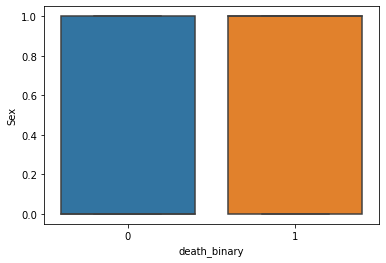

Age_at_CT


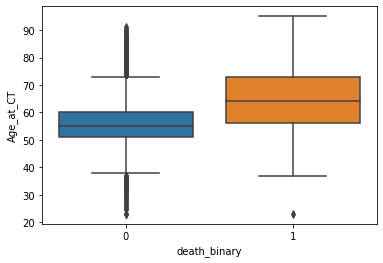

Tobacco


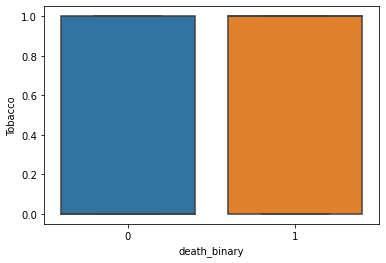

Alcohol_abuse


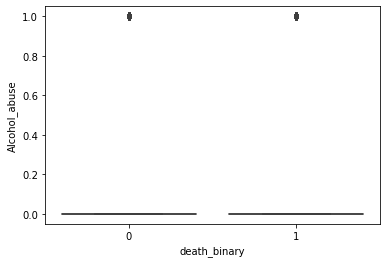

FRS_10-year_risk_(%)


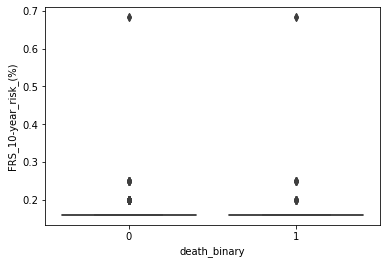

FRAX_10y_Fx_Prob_(Orange-w/_DXA)


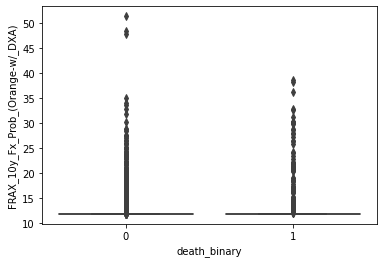

FRAX_10y_Hip_Fx_Prob_(Orange-w/_DXA)


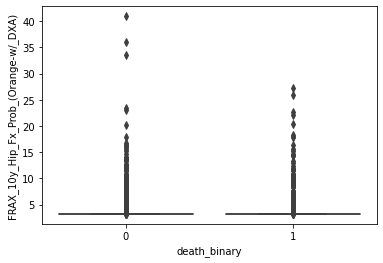

Met_Sx


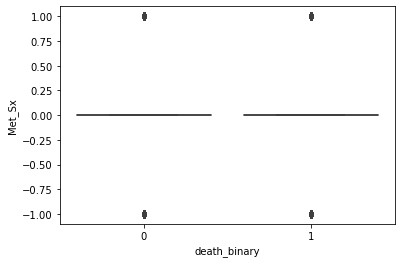

days


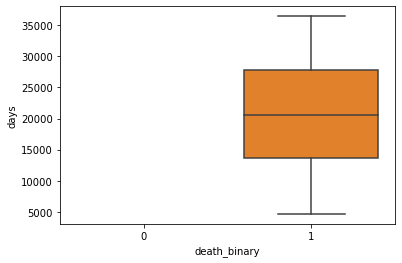

CVD


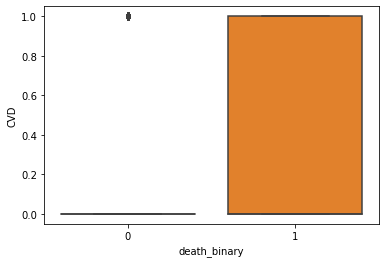

Heart_failure


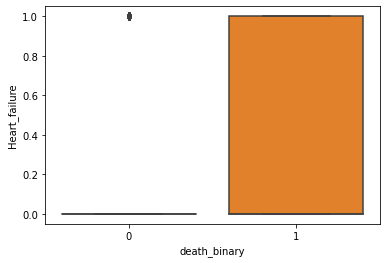

MI


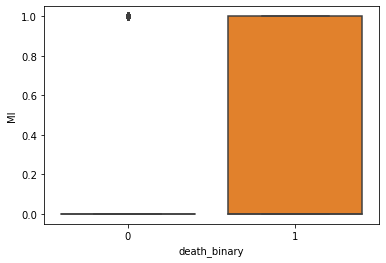

diabetes


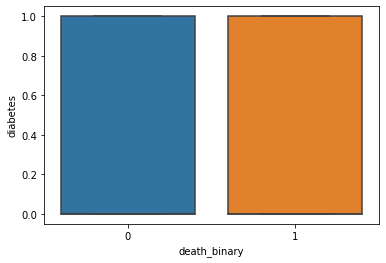

L1_HU_BMD


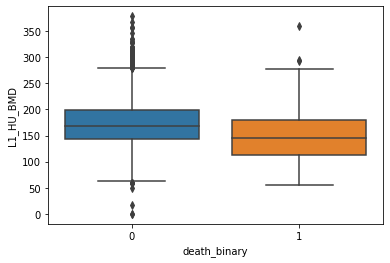

TAT_Area_(cm2)


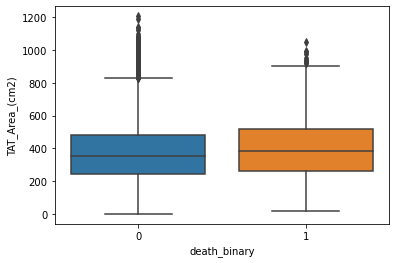

Total_Body_Area_EA_(cm2)


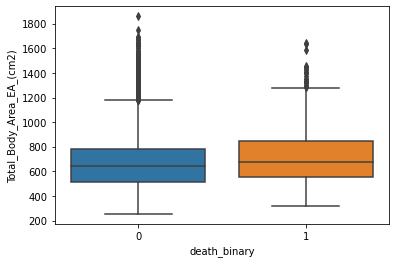

TAT/Body_Area


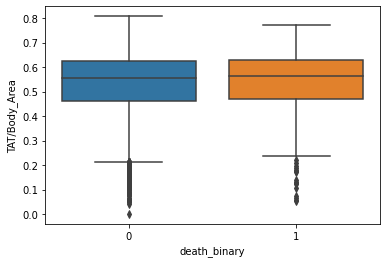

VAT_Area_(cm2)


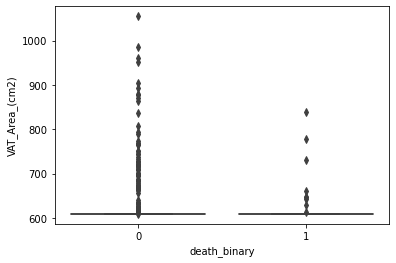

SAT_Area_(cm2)


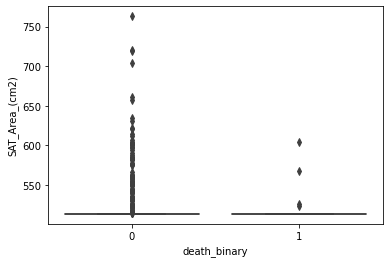

VAT/SAT_Ratio


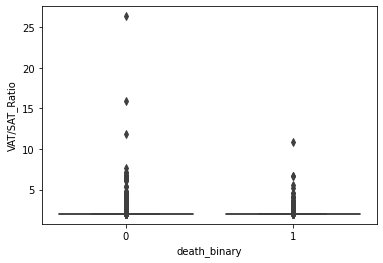

Muscle_HU


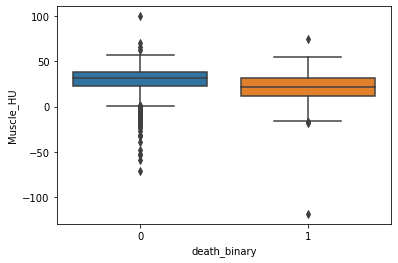

Muscle_Area_(cm2)


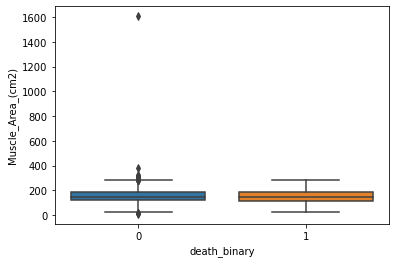

L3_SMI_(cm2/m2)


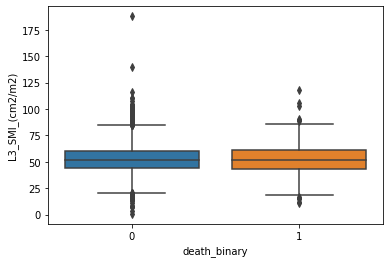

AoCa_Agatston


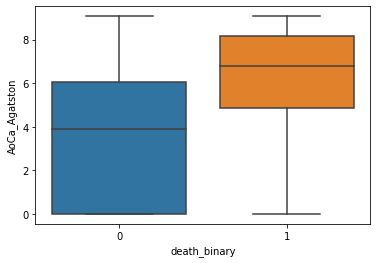

Liver_HU_(Median)


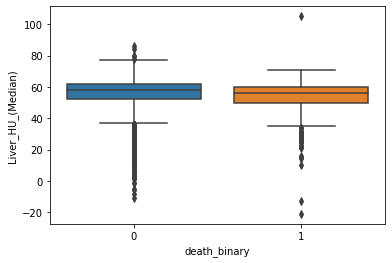

death_binary


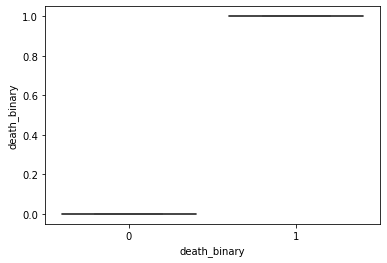

In [175]:
import seaborn as sns
for col in data.columns:
    print(col)
    sns.boxplot(x='death_binary', y=col, data=data)
    plt.show()

In [176]:
# ### Take non null values
# data = data[~data['days'].isna()]
# train_idx = pd.read_csv('Patients(RECORD_ID)TrainData.csv')['Record_ID']
# test_idx = pd.read_csv('Patients(RECORD_ID)_TestData.csv')['Record_ID']
# # print(train_idx)
# # train_idx = iter(train_idx)
# # test_idx = iter(test_idx)
# iterable = [train_idx, test_idx]

# feats = ['BMI', 'BMI_more_than_30',
#        'Sex', 'Age_at_CT', 'Tobacco', 'Alcohol_abuse', 'FRS_10-year_risk_(%)',
#        'FRAX_10y_Fx_Prob_(Orange-w/_DXA)','FRAX_10y_Hip_Fx_Prob_(Orange-w/_DXA)', 'Met_Sx', 'CVD',
#        'Heart_failure', 'MI', 'diabetes', 'L1_HU_BMD', 'TAT_Area_(cm2)',
#        'Total_Body_Area_EA_(cm2)', 'TAT/Body_Area', 'VAT_Area_(cm2)',
#        'SAT_Area_(cm2)', 'VAT/SAT_Ratio', 'Muscle_HU', 'Muscle_Area_(cm2)',
#        'L3_SMI_(cm2/m2)', 'AoCa_Agatston', 'Liver_HU_(Median)']

# label = 'days'

# train_scores, validation_scores = learning_curve(
# estimator = LinearRegression(),
# X = data[feats],
# y = data[label], cv = train_idx, cv = test_idx,
# scoring = 'neg_mean_squared_error')

In [177]:
train_idx = pd.read_csv('Patients(RECORD_ID)TrainData.csv')['Record_ID']
test_idx = pd.read_csv('Patients(RECORD_ID)_TestData.csv')['Record_ID']
train = data[data['Record_ID'].isin(train_idx)]
test = data[data['Record_ID'].isin(test_idx)]
print(train.shape)
print(test.shape)

(7363, 30)
(1860, 30)


In [178]:
# Train on Non-Null values
train = train[~train['days'].isna()]
val = test[~test['days'].isna()]

In [192]:
all_feats = ['BMI', 'BMI_more_than_30',
       'Sex', 'Age_at_CT', 'Tobacco', 'Alcohol_abuse', 'FRS_10-year_risk_(%)',
       'FRAX_10y_Fx_Prob_(Orange-w/_DXA)','FRAX_10y_Hip_Fx_Prob_(Orange-w/_DXA)', 'Met_Sx', 'CVD',
       'Heart_failure', 'MI', 'diabetes', 'L1_HU_BMD', 'TAT_Area_(cm2)',
       'Total_Body_Area_EA_(cm2)', 'TAT/Body_Area', 'VAT_Area_(cm2)',
       'SAT_Area_(cm2)', 'VAT/SAT_Ratio', 'Muscle_HU', 'Muscle_Area_(cm2)',
       'L3_SMI_(cm2/m2)', 'AoCa_Agatston', 'Liver_HU_(Median)']


ct_feats = ['L1_HU_BMD', 'TAT_Area_(cm2)',
       'Total_Body_Area_EA_(cm2)', 'TAT/Body_Area', 'VAT_Area_(cm2)',
       'SAT_Area_(cm2)', 'VAT/SAT_Ratio', 'Muscle_HU', 'Muscle_Area_(cm2)',
       'L3_SMI_(cm2/m2)', 'AoCa_Agatston', 'Liver_HU_(Median)']

feats = all_feats
#feats = [x for x in all_feats if x not in ct_feats]
#feats = ct_feats

label = 'days'
X_train = train[feats].values
Y_train = train[label].values
X_val = val[feats].values
chrono_val = val['Age_at_CT'].values
Y_val = val[label].values
X_test = test[feats].values
Y_test = test[label].values
chrono_test = test['Age_at_CT'].values
print(X_test.shape)
print(X_val.shape)
print(Y_val.shape)

(1860, 26)
(130, 26)
(130,)


In [193]:
eval_set = [(X_train, Y_train), (X_val, Y_val)]
model = xgb.XGBRegressor(n_estimators=500, max_depth=7, eta=0.01, subsample=1, colsample_bytree=1)
model.fit(X_train, Y_train, eval_metric='rmse', eval_set=eval_set)
# model = LinearRegression()
# model.fit(X_train, Y_train)

[0]	validation_0-rmse:22175.58594	validation_1-rmse:22417.25781
[1]	validation_0-rmse:21981.87500	validation_1-rmse:22235.08789
[2]	validation_0-rmse:21790.26172	validation_1-rmse:22054.91406
[3]	validation_0-rmse:21600.72852	validation_1-rmse:21877.02930
[4]	validation_0-rmse:21413.25586	validation_1-rmse:21701.10352
[5]	validation_0-rmse:21227.81836	validation_1-rmse:21527.12305
[6]	validation_0-rmse:21043.94336	validation_1-rmse:21359.90820
[7]	validation_0-rmse:20861.99805	validation_1-rmse:21192.79102
[8]	validation_0-rmse:20681.65039	validation_1-rmse:21027.32031
[9]	validation_0-rmse:20504.02734	validation_1-rmse:20865.96680
[10]	validation_0-rmse:20327.53516	validation_1-rmse:20704.65625
[11]	validation_0-rmse:20153.28516	validation_1-rmse:20544.91211
[12]	validation_0-rmse:19980.98828	validation_1-rmse:20389.48438
[13]	validation_0-rmse:19810.41602	validation_1-rmse:20232.50391
[14]	validation_0-rmse:19641.38867	validation_1-rmse:20079.17188
[15]	validation_0-rmse:19474.47852	

[127]	validation_0-rmse:8243.23828	validation_1-rmse:10983.42578
[128]	validation_0-rmse:8192.30273	validation_1-rmse:10954.85254
[129]	validation_0-rmse:8141.78711	validation_1-rmse:10924.98438
[130]	validation_0-rmse:8090.34375	validation_1-rmse:10894.42481
[131]	validation_0-rmse:8040.92920	validation_1-rmse:10867.27539
[132]	validation_0-rmse:7990.55371	validation_1-rmse:10837.81152
[133]	validation_0-rmse:7942.48340	validation_1-rmse:10811.61133
[134]	validation_0-rmse:7892.66113	validation_1-rmse:10783.58203
[135]	validation_0-rmse:7845.33984	validation_1-rmse:10759.20410
[136]	validation_0-rmse:7797.21826	validation_1-rmse:10732.43262
[137]	validation_0-rmse:7750.36084	validation_1-rmse:10705.59766
[138]	validation_0-rmse:7704.38721	validation_1-rmse:10684.11231
[139]	validation_0-rmse:7657.26660	validation_1-rmse:10659.36328
[140]	validation_0-rmse:7611.46387	validation_1-rmse:10633.06543
[141]	validation_0-rmse:7566.29980	validation_1-rmse:10610.42773
[142]	validation_0-rmse:7

[255]	validation_0-rmse:4483.45605	validation_1-rmse:9411.85938
[256]	validation_0-rmse:4469.50830	validation_1-rmse:9407.82519
[257]	validation_0-rmse:4456.09180	validation_1-rmse:9406.44238
[258]	validation_0-rmse:4442.64990	validation_1-rmse:9404.90234
[259]	validation_0-rmse:4424.37207	validation_1-rmse:9402.17773
[260]	validation_0-rmse:4412.17920	validation_1-rmse:9397.99121
[261]	validation_0-rmse:4398.16357	validation_1-rmse:9395.12891
[262]	validation_0-rmse:4384.99365	validation_1-rmse:9394.72266
[263]	validation_0-rmse:4365.92676	validation_1-rmse:9393.00977
[264]	validation_0-rmse:4353.52148	validation_1-rmse:9391.75879
[265]	validation_0-rmse:4341.04785	validation_1-rmse:9389.40918
[266]	validation_0-rmse:4323.46777	validation_1-rmse:9387.81250
[267]	validation_0-rmse:4310.99316	validation_1-rmse:9386.67969
[268]	validation_0-rmse:4298.94580	validation_1-rmse:9384.83496
[269]	validation_0-rmse:4286.32617	validation_1-rmse:9382.39453
[270]	validation_0-rmse:4271.16846	valid

[384]	validation_0-rmse:3083.87329	validation_1-rmse:9370.10547
[385]	validation_0-rmse:3077.06055	validation_1-rmse:9369.27051
[386]	validation_0-rmse:3069.53882	validation_1-rmse:9370.10059
[387]	validation_0-rmse:3063.47925	validation_1-rmse:9370.13965
[388]	validation_0-rmse:3057.86621	validation_1-rmse:9369.32031
[389]	validation_0-rmse:3051.91919	validation_1-rmse:9369.38672
[390]	validation_0-rmse:3046.41943	validation_1-rmse:9368.60254
[391]	validation_0-rmse:3040.05200	validation_1-rmse:9368.92481
[392]	validation_0-rmse:3035.09033	validation_1-rmse:9368.94727
[393]	validation_0-rmse:3028.05444	validation_1-rmse:9369.76953
[394]	validation_0-rmse:3021.45361	validation_1-rmse:9370.95801
[395]	validation_0-rmse:3013.97607	validation_1-rmse:9371.21289
[396]	validation_0-rmse:3007.15503	validation_1-rmse:9372.07422
[397]	validation_0-rmse:3001.16919	validation_1-rmse:9370.33984
[398]	validation_0-rmse:2995.71069	validation_1-rmse:9371.00195
[399]	validation_0-rmse:2990.34790	valid

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
             eta=0.01, gamma=0, gpu_id=-1, importance_type=None,
             interaction_constraints='', learning_rate=0.00999999978,
             max_delta_step=0, max_depth=7, min_child_weight=1, missing=nan,
             monotone_constraints='()', n_estimators=500, n_jobs=8,
             num_parallel_tree=1, predictor='auto', random_state=0, reg_alpha=0,
             reg_lambda=1, scale_pos_weight=1, subsample=1, tree_method='exact',
             validate_parameters=1, verbosity=None)

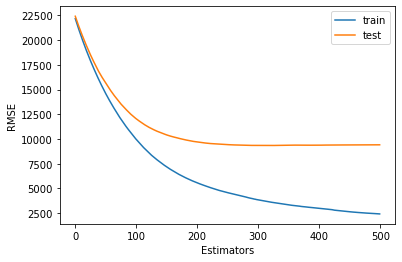

In [194]:
results = model.evals_result()
plt.plot(results['validation_0']['rmse'], label='train')
plt.plot(results['validation_1']['rmse'], label='test')
plt.legend()
plt.xlabel('Estimators')
plt.ylabel('RMSE')
plt.show()

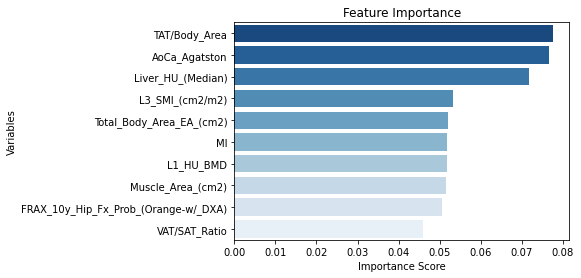

In [195]:
variables_df = pd.DataFrame(feats, columns=['Variables'])
importance_score_df = pd.DataFrame(model.feature_importances_, columns=['Importance Score'])

# print(variables_df)
# print(importance_score_df)

feature_imp = pd.concat([variables_df, importance_score_df], axis=1)
feature_imp = feature_imp.sort_values(by='Importance Score', ascending=False)
feature_imp = feature_imp.reset_index()
x = 'Importance Score'
y = 'Variables'
sns.barplot(x=x, y=y, data=feature_imp[:10], orient="h", palette="Blues_r")
plt.title('Feature Importance')
plt.show()

9408.819972918756 20924.475699779592
(130,)


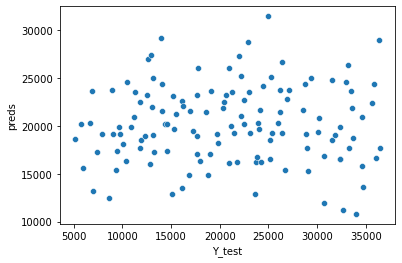

/opt/homebrew/Caskroom/miniforge/base/envs/pytorch_env/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


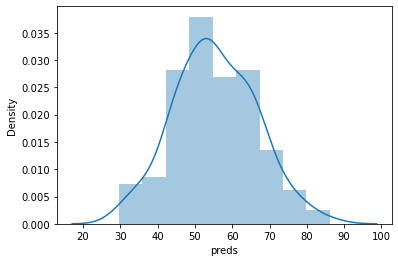

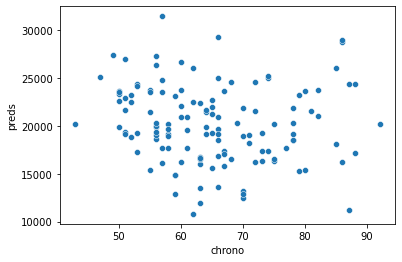

In [196]:
preds = model.predict(X_val)
rmse = math.sqrt(mean_squared_error(Y_val, preds))
print(rmse, Y_val.mean())

#print(X_val)
print(Y_val.shape)
# 'chrono': X_val.loc['Age_at_CT']
tmp = {'Y_test':Y_val,'preds':preds, 'chrono': chrono_val} 
tmp_df = pd.DataFrame(tmp)
tmp_df.sort_values(by='Y_test', inplace=True)
sns.scatterplot(data=tmp_df, x='Y_test', y='preds')
plt.show()
sns.distplot(tmp_df['preds']/365)
plt.show()
sns.scatterplot(data=tmp_df, x='chrono', y='preds')
plt.show()
# print(Y_val.shape)

                  0
count    130.000000
mean   20200.736328
std     4029.256104
min    10804.107422
25%    17340.300293
50%    19892.875977
75%    23265.937012
max    31456.070312
                  0
count   1730.000000
mean   20469.179688
std     3396.311768
min     8999.958984
25%    18221.673828
50%    20602.481445
75%    22626.896484
max    31777.125000
                  0
count   1860.000000
mean   20450.417969
std     3443.770752
min     8999.958984
25%    18165.235840
50%    20570.614258
75%    22655.368164
max    31777.125000
(1860,)


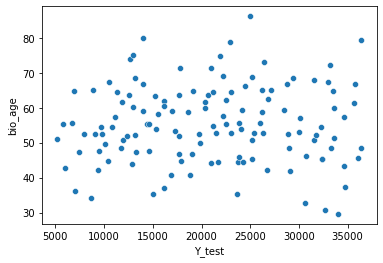

/opt/homebrew/Caskroom/miniforge/base/envs/pytorch_env/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


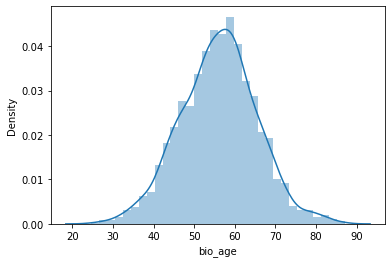

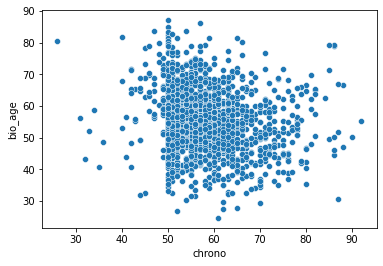

Error% for Non-zero values: 0.4497


<AxesSubplot:xlabel='Y_test_cat', ylabel='preds'>

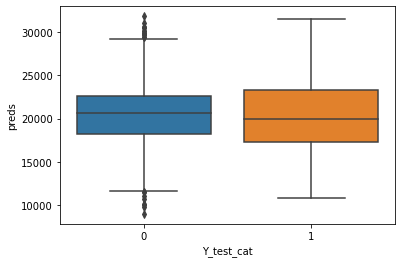

In [210]:
# Prediting on Null values

test_null = test[test['days'].isna()]
X_test_null = test_null[feats].values
preds_test_null = model.predict(X_test_null)

tmp_df = pd.DataFrame(preds)
print(tmp_df.describe())
tmp_df = pd.DataFrame(preds_test_null)
print(tmp_df.describe())

all_preds = model.predict(X_test)
tmp_df = pd.DataFrame(all_preds)
print(tmp_df.describe())

tmp = {'Y_test':Y_test,'bio_age':all_preds, 'chrono': chrono_test} 
tmp_df = pd.DataFrame(tmp)
tmp_df.sort_values(by='Y_test', inplace=True)
tmp_df['bio_age'] = tmp_df['bio_age']/365
print(tmp_df['bio_age'].shape)
sns.scatterplot(data=tmp_df, x='Y_test', y='bio_age')
plt.show()
sns.distplot(tmp_df['bio_age'])
plt.show()
sns.scatterplot(data=tmp_df, x='chrono', y='bio_age')
plt.show()


tmp = {'Y_test':Y_test,'preds':all_preds}
tmp_df = pd.DataFrame(tmp)
y_nz = tmp_df[~tmp_df['Y_test'].isna()]['Y_test']
preds_nz = tmp_df[~tmp_df['Y_test'].isna()]['preds']
rmse = math.sqrt(mean_squared_error(y_nz, preds_nz))
print("Error% for Non-zero values: {:0.4f}".format((rmse/y_nz.mean())))
 

tmp_df['Y_test_cat'] = np.where(tmp_df['Y_test'].isna(), 0, 1)
sns.boxplot(data=tmp_df, x='Y_test_cat', y='preds')



(1860,)


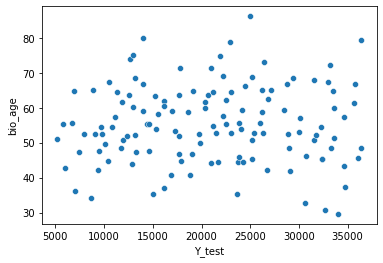

/opt/homebrew/Caskroom/miniforge/base/envs/pytorch_env/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


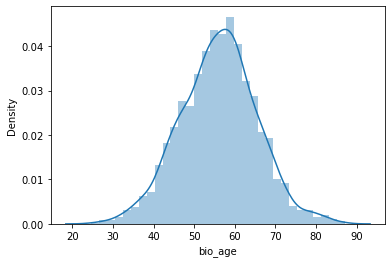

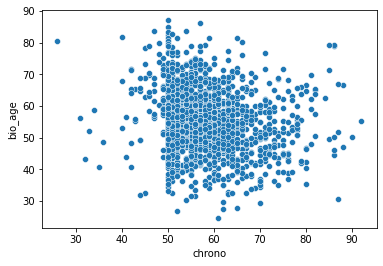

In [212]:
tmp = {'Y_test':Y_test,'bio_age':all_preds, 'chrono': chrono_test} 
tmp_df = pd.DataFrame(tmp)
tmp_df.sort_values(by='Y_test', inplace=True)
tmp_df['bio_age'] = tmp_df['bio_age']/365
print(tmp_df['bio_age'].shape)
sns.scatterplot(data=tmp_df, x='Y_test', y='bio_age')
plt.show()
sns.distplot(tmp_df['bio_age'])
plt.show()
sns.scatterplot(data=tmp_df, x='chrono', y='bio_age')
plt.show()

(845, 4)


<AxesSubplot:xlabel='Chronological_Age', ylabel='Biological_Age'>

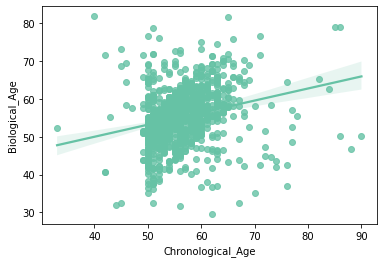

In [238]:
th = 10
tmp = tmp_df.copy()
X = tmp[['chrono']]
Y = tmp['bio_age']
model = LinearRegression().fit(X,Y)

# tmp['preds_new'] = model.predict(X)
tmp['preds_new'] = 1.5 * X - 30
tmp_1 = tmp[abs(tmp['preds_new'] - tmp['bio_age'])<th]
print(tmp_1.shape)
tmp_2 = tmp.sample(tmp_1.shape[0]//3)
fnl_tmp = pd.concat([tmp_1, tmp_2], ignore_index=True)
#fnl_tmp['biological_age'] = fnl_tmp['bio_age']
fnl_tmp.rename(columns={'bio_age':'Biological_Age','chrono':'Chronological_Age'}, inplace=True)
# sns.set_palette('Set2')
sns.regplot(data=fnl_tmp, x='Chronological_Age', y='Biological_Age')

1

In [ ]:
tmp_2 = tmp.sample(tmp_1.shape[0]/2)
fnl_tmp = pd.concat([tmp_1, tmp_2], ignore_index=True

/opt/homebrew/Caskroom/miniforge/base/envs/pytorch_env/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


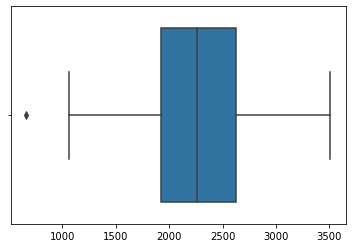

/opt/homebrew/Caskroom/miniforge/base/envs/pytorch_env/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


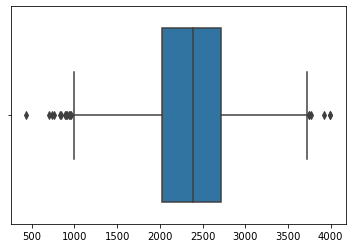

/opt/homebrew/Caskroom/miniforge/base/envs/pytorch_env/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:>

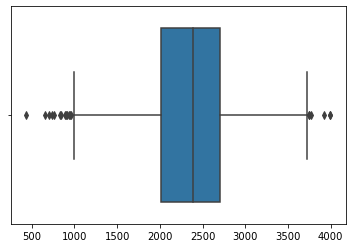

In [15]:
sns.boxplot(preds)
plt.show()
sns.boxplot(preds_test_null)
plt.show()
sns.boxplot(all_preds)